# Notes

This is a cleaned-up version of Paper_Plots_Fitting.ipynb which tries to accurately fit the histograms of DM contributions from different types of structure.

It uses the information about the best functions to use for fitting which I learned in:

Illustris_Zhang_Method/Paper_Plots_Fitting.ipynb
Illustris_Zhang_Method/Find_Best_Fit.ipynb

It uses the data which was generated in:

Illustris_Zhang_Method/Pipe_LSS_Analysis_5.ipynb

# Imports

In [674]:
import numpy as np
from scipy import stats
from scipy.interpolate import interp1d
from matplotlib import pyplot as plt
from astropy.modeling import models, fitting
from astropy.modeling.models import custom_model
from scipy.stats import gumbel_l, lognorm,gilbrat,fisk
from scipy.signal import convolve
from scipy.integrate import simps
from scipy.stats import ks_2samp
from scipy.stats import rv_continuous 
from scipy.interpolate import interp1d
from scipy.integrate import cumtrapz

In [675]:
#lognorm.pdf?
#gilbrat?
#fisk?

# Define custom models

In [1133]:
@custom_model
def my_model(x,loc=0,scale=1):
    """
    Model of the Gumbel (minimum) distribution for fitting with astropy.
    Defining my own model is based on: https://docs.astropy.org/en/stable/modeling/new-model.html
    Distribution idea from: https://docs.astropy.org/en/stable/modeling/new-model.html
    Distribution from: https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.gumbel_l.html
    
    """
    
    #the original  gumbel function:
    eqn = gumbel_l.pdf(x,loc,scale)
    
    #note: it must return P(DM)=zero for DMs below zero
    #so modify by a function which is 1 for 0 and positive,
    #and zero for negative values. See:
    #https://math.stackexchange.com/questions/1403746/function-that-returns-0-for-all-negative-values

    eqn*=(0**(np.sqrt(x**2)-x))
    
    return eqn

@custom_model
def my_model_2(x,amp=1,loc=0,scale=1):
    """
    Model of the Gumbel (minimum) distribution for fitting with astropy.
    Defining my own model is based on: https://docs.astropy.org/en/stable/modeling/new-model.html
    Distribution idea from: https://docs.astropy.org/en/stable/modeling/new-model.html
    Distribution from: https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.gumbel_l.html
    
    """
    
    #the original  gumbel function derived myself:
    f=(x-loc)/scale
    eqn = np.exp(f-np.exp(f))/scale
    
    #eqn = amp*gumbel_l.pdf(x,loc,scale)
    
    #note: it must return P(DM)=zero for DMs below zero
    #so modify by a function which is 1 for 0 and positive,
    #and zero for negative values. See:
    #https://math.stackexchange.com/questions/1403746/function-that-returns-0-for-all-negative-values

    eqn*=(0**(np.sqrt(x**2)-x))
    
    return eqn

@custom_model
def my_model_3(x,amp=1,loc=0,scale=1):
    """
    Model of the Gumbel (minimum) distribution for fitting with astropy.
    Defining my own model is based on: https://docs.astropy.org/en/stable/modeling/new-model.html
    Distribution idea from: https://docs.astropy.org/en/stable/modeling/new-model.html
    Distribution from: https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.gumbel_l.html
    
    """
    
    #the original  gumbel function modified by an amplitude:
    f=(x-loc)/scale
    
    eqn = amp*np.exp(f-np.exp(f))/scale
    
    #eqn = amp*gumbel_l.pdf(x,loc,scale)
    
    #note: it must return P(DM)=zero for DMs below zero
    #so modify by a function which is 1 for 0 and positive,
    #and zero for negative values. See:
    #https://math.stackexchange.com/questions/1403746/function-that-returns-0-for-all-negative-values

    eqn*=(0**(np.sqrt(x**2)-x))
    
    return eqn

@custom_model
def my_model_4(x,amp=1,loc=0,scale=1):
    """
    Model of the Gumbel (minimum) distribution for fitting with astropy.
    Defining my own model is based on: https://docs.astropy.org/en/stable/modeling/new-model.html
    Distribution idea from: https://docs.astropy.org/en/stable/modeling/new-model.html
    Distribution from: https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.gumbel_l.html
    
    """
    
    x=np.log(x)
    
    #the original  gumbel function modified by an amplitude:
    f=(x-loc)/scale
    
    eqn = amp*np.exp(f-np.exp(f))/scale
    
    #eqn = amp*gumbel_l.pdf(x,loc,scale)
    
    #note: it must return P(DM)=zero for DMs below zero
    #so modify by a function which is 1 for 0 and positive,
    #and zero for negative values. See:
    #https://math.stackexchange.com/questions/1403746/function-that-returns-0-for-all-negative-values

    eqn*=(0**(np.sqrt(x**2)-x))
    
    return eqn

@custom_model
def my_model_5(x,amp=1,loc=0,scale=1,amp2=1,loc2=0,scale2=1):
    """
    Model of the Gumbel (minimum) distribution for fitting with astropy.
    Defining my own model is based on: https://docs.astropy.org/en/stable/modeling/new-model.html
    Distribution idea from: https://docs.astropy.org/en/stable/modeling/new-model.html
    Distribution from: https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.gumbel_l.html
    
    """
    
    x=np.log(x)
    
    #the original  gumbel function modified by an amplitude:
    f=(x-loc)/scale
    
    eqn = amp*np.exp(f-np.exp(f))/scale
    
    #eqn = amp*gumbel_l.pdf(x,loc,scale)
    
    #note: it must return P(DM)=zero for DMs below zero
    #so modify by a function which is 1 for 0 and positive,
    #and zero for negative values. See:
    #https://math.stackexchange.com/questions/1403746/function-that-returns-0-for-all-negative-values

    eqn*=(0**(np.sqrt(x**2)-x))
    
    #multiply by something to boost the higher DM tail
    
    #try a gaussian
    g=(x-loc2)/scale2
    mod = amp2*np.exp(-1*(g**2)/2)/np.sqrt(2*np.pi)
    eqn+=mod
    
    
    
    return eqn

# Functions

In [ ]:
def get_inverted_cdf(xs, pdfs):
    """
    Method to get an inverted cdf for a pdf. Can be used alongside sample_fn()
    to randomly draw values distributed according to the pdf via inversion
    sampling.
    
    from:  https://cosmiccoding.com.au/tutorials/inversion_sampling
    
    Inputs:
    
    xs : [array-like] the x values of the pdf
    pdfs : [array-like] the probability P(x) of these xs
    
    Returns:
    
    an inverted cdf which can be used with sample_fn() to draw from the
    original pdf.
    
    """
    cdfs = cumtrapz(pdfs, x=xs) # Get the CDF using a very fast trapz rule
    cdfs = cdfs / cdfs.max()  # Ensure its normalised, to cater for unnormalised PDFs
    cdfs = np.insert(cdfs, 0, 0)  # Add the 0 area to start of the CDF array
    return interp1d(cdfs, xs, kind="linear")  # return interpolation from cdf -> x
    
def sample_fn(fn, n=1):
    """
    Function for sampling from an inverted pdf created by get_inverted_cdf().
    
    from:  https://cosmiccoding.com.au/tutorials/inversion_sampling
    
    Input:
    
    fn : the inverted cdf provided by get_inverted_cdf()
    
    returns :
    
    a set of samples drawn from the pdf.
    """
    return fn(np.random.random(size=n))



In [746]:
#################################
#define custom halo distribution#
#################################

class Halo_Custom_Dist(stats.rv_continuous):
    
    #define init with variable parameters
    def __init__(self, amp, loc, scale, *args, **kwargs):
        super().__init__(*args, **kwargs)
        #init our parameters
        self.amp = amp
        self.loc = loc
        self.scale = scale
        #init our cdf and ppf functions
        self.df_func,self.ppf_func = self.create_cdf_ppf()
        
    #function to return the Halo distribution
    def norm_hal(self,x,amp,loc,scale):
        
        #using astropy
        eqn = scipy_gumbel(amp=amp,
                           loc=loc,
                           scale=scale)(x)
                
        #note: it must return P(DM)=zero for DMs below zero
        #so modify by a function which is 1 for 0 and positive,
        #and zero for negative values. See:
        #https://math.stackexchange.com/questions/1403746/function-that-returns-0-for-all-negative-values
        
        #eqn*=(0**(np.sqrt(x**2)-x))
        
        
        return eqn
    
    #function to normalise the pdf over the chosen domain
    def normalisation(self, x):
        return simps(self.pdf(x), x)
    
    #function to...
    def create_cdf_ppf(self):
        # define domain as +/-25 sigma
        #xs = np.linspace(-25, 25, 10000001)
        xs = np.linspace(0, 10000, 100000001) #charlie test domain 08/12/2022

        # normalise our pdf to sum to 1 so it satisfies a distribution
        norm_constant = self.normalisation(xs)
        # compute pdfs to be summed to form cdf
        my_pdfs = self.pdf(xs) / norm_constant
        # cumsum to form cdf
        my_cdf = np.cumsum(my_pdfs)
        # make sure cdf bounded on [0,1]
        my_cdf = my_cdf / my_cdf[-1]
        # create cdf and ppf
        func_cdf = interp1d(xs, my_cdf)
        func_ppf = interp1d(my_cdf, xs, fill_value='extrapolate')
        return func_cdf, func_ppf
    
    def _pdf(self,x):
        return self.norm_hal(x,amp=self.amp,loc=self.loc,scale=self.scale)
    
    # cdf function
    def _cdf(self, x):
        return self.cdf_func(x)
    
    # inverse cdf function
    def _ppf(self, x):
        return self.ppf_func(x)

# Begin

## Load all DM histogram data which will be fitted

### Simulation to load data for

In [678]:
sim_to_load = 'TNG300-1'

### The original DM data which was histogrammed

In [679]:
DMs_Tot_99 = np.load('./Stored_Pipe_DM_Values/Tot_DMs_sim_{0}_snap_99.npy'.format(sim_to_load))
DMs_Hal_99 = np.load('./Stored_Pipe_DM_Values/Hal_DMs_sim_{0}_snap_99.npy'.format(sim_to_load))
DMs_Fil_99 = np.load('./Stored_Pipe_DM_Values/Fil_DMs_sim_{0}_snap_99.npy'.format(sim_to_load))
DMs_Voi_99 = np.load('./Stored_Pipe_DM_Values/Voi_DMs_sim_{0}_snap_99.npy'.format(sim_to_load))

DMs_Tot_91 = np.load('./Stored_Pipe_DM_Values/Tot_DMs_sim_{0}_snap_91.npy'.format(sim_to_load))
DMs_Hal_91 = np.load('./Stored_Pipe_DM_Values/Hal_DMs_sim_{0}_snap_91.npy'.format(sim_to_load))
DMs_Fil_91 = np.load('./Stored_Pipe_DM_Values/Fil_DMs_sim_{0}_snap_91.npy'.format(sim_to_load))
DMs_Voi_91 = np.load('./Stored_Pipe_DM_Values/Voi_DMs_sim_{0}_snap_91.npy'.format(sim_to_load))

DMs_Tot_84 = np.load('./Stored_Pipe_DM_Values/Tot_DMs_sim_{0}_snap_84.npy'.format(sim_to_load))
DMs_Hal_84 = np.load('./Stored_Pipe_DM_Values/Hal_DMs_sim_{0}_snap_84.npy'.format(sim_to_load))
DMs_Fil_84 = np.load('./Stored_Pipe_DM_Values/Fil_DMs_sim_{0}_snap_84.npy'.format(sim_to_load))
DMs_Voi_84 = np.load('./Stored_Pipe_DM_Values/Voi_DMs_sim_{0}_snap_84.npy'.format(sim_to_load))

DMs_Tot_78 = np.load('./Stored_Pipe_DM_Values/Tot_DMs_sim_{0}_snap_78.npy'.format(sim_to_load))
DMs_Hal_78 = np.load('./Stored_Pipe_DM_Values/Hal_DMs_sim_{0}_snap_78.npy'.format(sim_to_load))
DMs_Fil_78 = np.load('./Stored_Pipe_DM_Values/Fil_DMs_sim_{0}_snap_78.npy'.format(sim_to_load))
DMs_Voi_78 = np.load('./Stored_Pipe_DM_Values/Voi_DMs_sim_{0}_snap_78.npy'.format(sim_to_load))

DMs_Tot_72 = np.load('./Stored_Pipe_DM_Values/Tot_DMs_sim_{0}_snap_72.npy'.format(sim_to_load))
DMs_Hal_72 = np.load('./Stored_Pipe_DM_Values/Hal_DMs_sim_{0}_snap_72.npy'.format(sim_to_load))
DMs_Fil_72 = np.load('./Stored_Pipe_DM_Values/Fil_DMs_sim_{0}_snap_72.npy'.format(sim_to_load))
DMs_Voi_72 = np.load('./Stored_Pipe_DM_Values/Voi_DMs_sim_{0}_snap_72.npy'.format(sim_to_load))

DMs_Tot_67 = np.load('./Stored_Pipe_DM_Values/Tot_DMs_sim_{0}_snap_67.npy'.format(sim_to_load))
DMs_Hal_67 = np.load('./Stored_Pipe_DM_Values/Hal_DMs_sim_{0}_snap_67.npy'.format(sim_to_load))
DMs_Fil_67 = np.load('./Stored_Pipe_DM_Values/Fil_DMs_sim_{0}_snap_67.npy'.format(sim_to_load))
DMs_Voi_67 = np.load('./Stored_Pipe_DM_Values/Voi_DMs_sim_{0}_snap_67.npy'.format(sim_to_load))

DMs_Tot_59 = np.load('./Stored_Pipe_DM_Values/Tot_DMs_sim_{0}_snap_59.npy'.format(sim_to_load))
DMs_Hal_59 = np.load('./Stored_Pipe_DM_Values/Hal_DMs_sim_{0}_snap_59.npy'.format(sim_to_load))
DMs_Fil_59 = np.load('./Stored_Pipe_DM_Values/Fil_DMs_sim_{0}_snap_59.npy'.format(sim_to_load))
DMs_Voi_59 = np.load('./Stored_Pipe_DM_Values/Voi_DMs_sim_{0}_snap_59.npy'.format(sim_to_load))

DMs_Tot_50 = np.load('./Stored_Pipe_DM_Values/Tot_DMs_sim_{0}_snap_50.npy'.format(sim_to_load))
DMs_Hal_50 = np.load('./Stored_Pipe_DM_Values/Hal_DMs_sim_{0}_snap_50.npy'.format(sim_to_load))
DMs_Fil_50 = np.load('./Stored_Pipe_DM_Values/Fil_DMs_sim_{0}_snap_50.npy'.format(sim_to_load))
DMs_Voi_50 = np.load('./Stored_Pipe_DM_Values/Voi_DMs_sim_{0}_snap_50.npy'.format(sim_to_load))

DMs_Tot_40 = np.load('./Stored_Pipe_DM_Values/Tot_DMs_sim_{0}_snap_40.npy'.format(sim_to_load))
DMs_Hal_40 = np.load('./Stored_Pipe_DM_Values/Hal_DMs_sim_{0}_snap_40.npy'.format(sim_to_load))
DMs_Fil_40 = np.load('./Stored_Pipe_DM_Values/Fil_DMs_sim_{0}_snap_40.npy'.format(sim_to_load))
DMs_Voi_40 = np.load('./Stored_Pipe_DM_Values/Voi_DMs_sim_{0}_snap_40.npy'.format(sim_to_load))

DMs_Tot_33 = np.load('./Stored_Pipe_DM_Values/Tot_DMs_sim_{0}_snap_33.npy'.format(sim_to_load))
DMs_Hal_33 = np.load('./Stored_Pipe_DM_Values/Hal_DMs_sim_{0}_snap_33.npy'.format(sim_to_load))
DMs_Fil_33 = np.load('./Stored_Pipe_DM_Values/Fil_DMs_sim_{0}_snap_33.npy'.format(sim_to_load))
DMs_Voi_33 = np.load('./Stored_Pipe_DM_Values/Voi_DMs_sim_{0}_snap_33.npy'.format(sim_to_load))

DMs_Tot_25 = np.load('./Stored_Pipe_DM_Values/Tot_DMs_sim_{0}_snap_25.npy'.format(sim_to_load))
DMs_Hal_25 = np.load('./Stored_Pipe_DM_Values/Hal_DMs_sim_{0}_snap_25.npy'.format(sim_to_load))
DMs_Fil_25 = np.load('./Stored_Pipe_DM_Values/Fil_DMs_sim_{0}_snap_25.npy'.format(sim_to_load))
DMs_Voi_25 = np.load('./Stored_Pipe_DM_Values/Voi_DMs_sim_{0}_snap_25.npy'.format(sim_to_load))

DMs_Tot_21 = np.load('./Stored_Pipe_DM_Values/Tot_DMs_sim_{0}_snap_21.npy'.format(sim_to_load))
DMs_Hal_21 = np.load('./Stored_Pipe_DM_Values/Hal_DMs_sim_{0}_snap_21.npy'.format(sim_to_load))
DMs_Fil_21 = np.load('./Stored_Pipe_DM_Values/Fil_DMs_sim_{0}_snap_21.npy'.format(sim_to_load))
DMs_Voi_21 = np.load('./Stored_Pipe_DM_Values/Voi_DMs_sim_{0}_snap_21.npy'.format(sim_to_load))

DMs_Tot_17 = np.load('./Stored_Pipe_DM_Values/Tot_DMs_sim_{0}_snap_17.npy'.format(sim_to_load))
DMs_Hal_17 = np.load('./Stored_Pipe_DM_Values/Hal_DMs_sim_{0}_snap_17.npy'.format(sim_to_load))
DMs_Fil_17 = np.load('./Stored_Pipe_DM_Values/Fil_DMs_sim_{0}_snap_17.npy'.format(sim_to_load))
DMs_Voi_17 = np.load('./Stored_Pipe_DM_Values/Voi_DMs_sim_{0}_snap_17.npy'.format(sim_to_load))

In [680]:
#put data into handy array form
Tot_data = [DMs_Tot_99,
            DMs_Tot_91,
            DMs_Tot_84,
            DMs_Tot_78,
            DMs_Tot_72,
            DMs_Tot_67,
            DMs_Tot_59,
            DMs_Tot_50,
            DMs_Tot_40,
            DMs_Tot_33,
            DMs_Tot_25,
            DMs_Tot_21,
            DMs_Tot_17]

Hal_data = [DMs_Hal_99,
            DMs_Hal_91,
            DMs_Hal_84,
            DMs_Hal_78,
            DMs_Hal_72,
            DMs_Hal_67,
            DMs_Hal_59,
            DMs_Hal_50,
            DMs_Hal_40,
            DMs_Hal_33,
            DMs_Hal_25,
            DMs_Hal_21,
            DMs_Hal_17]

Fil_data = [DMs_Fil_99,
            DMs_Fil_91,
            DMs_Fil_84,
            DMs_Fil_78,
            DMs_Fil_72,
            DMs_Fil_67,
            DMs_Fil_59,
            DMs_Fil_50,
            DMs_Fil_40,
            DMs_Fil_33,
            DMs_Fil_25,
            DMs_Fil_21,
            DMs_Fil_17]

Voi_data = [DMs_Voi_99,
            DMs_Voi_91,
            DMs_Voi_84,
            DMs_Voi_78,
            DMs_Voi_72,
            DMs_Voi_67,
            DMs_Voi_59,
            DMs_Voi_50,
            DMs_Voi_40,
            DMs_Voi_33,
            DMs_Voi_25,
            DMs_Voi_21,
            DMs_Voi_17]


### The redshifts of the snapshots DM histograms were created for

In [681]:
snap_z_list = np.load('Paper_DM-z_Hists_Redshifts_{0}.npy'.format(sim_to_load))
print('number of snapshots: {0}'.format(len(snap_z_list)))
#print('snapshot redshifts: {0}'.format(snap_z_list))

number of snapshots: 13


### The bin edges of the created DM histograms

In [682]:
bin_edges = np.load('Paper_DM-z_Hists_BinEdges_{0}.npy'.format(sim_to_load))
print('number of bin edges: {0}'.format(len(bin_edges)))
#print('the bin edges: {0}'.format(bin_edges))

number of bin edges: 1000


### The un-normalised histograms

In [683]:
Tot_DM_unorm = np.load('Paper_DM-z_Hists_TotCounts_{0}_Dens_False.npy'.format(sim_to_load))
Hal_DM_unorm = np.load('Paper_DM-z_Hists_HalCounts_{0}_Dens_False.npy'.format(sim_to_load))
Fil_DM_unorm = np.load('Paper_DM-z_Hists_FilCounts_{0}_Dens_False.npy'.format(sim_to_load))
Voi_DM_unorm = np.load('Paper_DM-z_Hists_VoiCounts_{0}_Dens_False.npy'.format(sim_to_load))
print('Data loaded.')
print('Data shape: {0}. Number of histograms: {1}'.format(Tot_DM_unorm.shape,Tot_DM_unorm.shape[0]))

Data loaded.
Data shape: (13, 999). Number of histograms: 13


### The normalised histograms

In [684]:
Tot_DM_norm = np.load('Paper_DM-z_Hists_TotCounts_{0}.npy'.format(sim_to_load))
Hal_DM_norm = np.load('Paper_DM-z_Hists_HalCounts_{0}.npy'.format(sim_to_load))
Fil_DM_norm = np.load('Paper_DM-z_Hists_FilCounts_{0}.npy'.format(sim_to_load))
Voi_DM_norm = np.load('Paper_DM-z_Hists_VoiCounts_{0}.npy'.format(sim_to_load))
print('Data loaded.')
print('Data shape: {0}. Number of histograms: {1}'.format(Tot_DM_norm.shape,Tot_DM_norm.shape[0]))

Data loaded.
Data shape: (13, 999). Number of histograms: 13


## Plot the histograms

### The normalised histograms

loop: 1, redshift: 0.10
loop: 2, redshift: 0.20
loop: 3, redshift: 0.30
loop: 4, redshift: 0.40
loop: 5, redshift: 0.50
loop: 6, redshift: 0.70
loop: 7, redshift: 1.00
loop: 8, redshift: 1.50
loop: 9, redshift: 2.00
loop: 10, redshift: 3.01
loop: 11, redshift: 4.01
loop: 12, redshift: 5.00


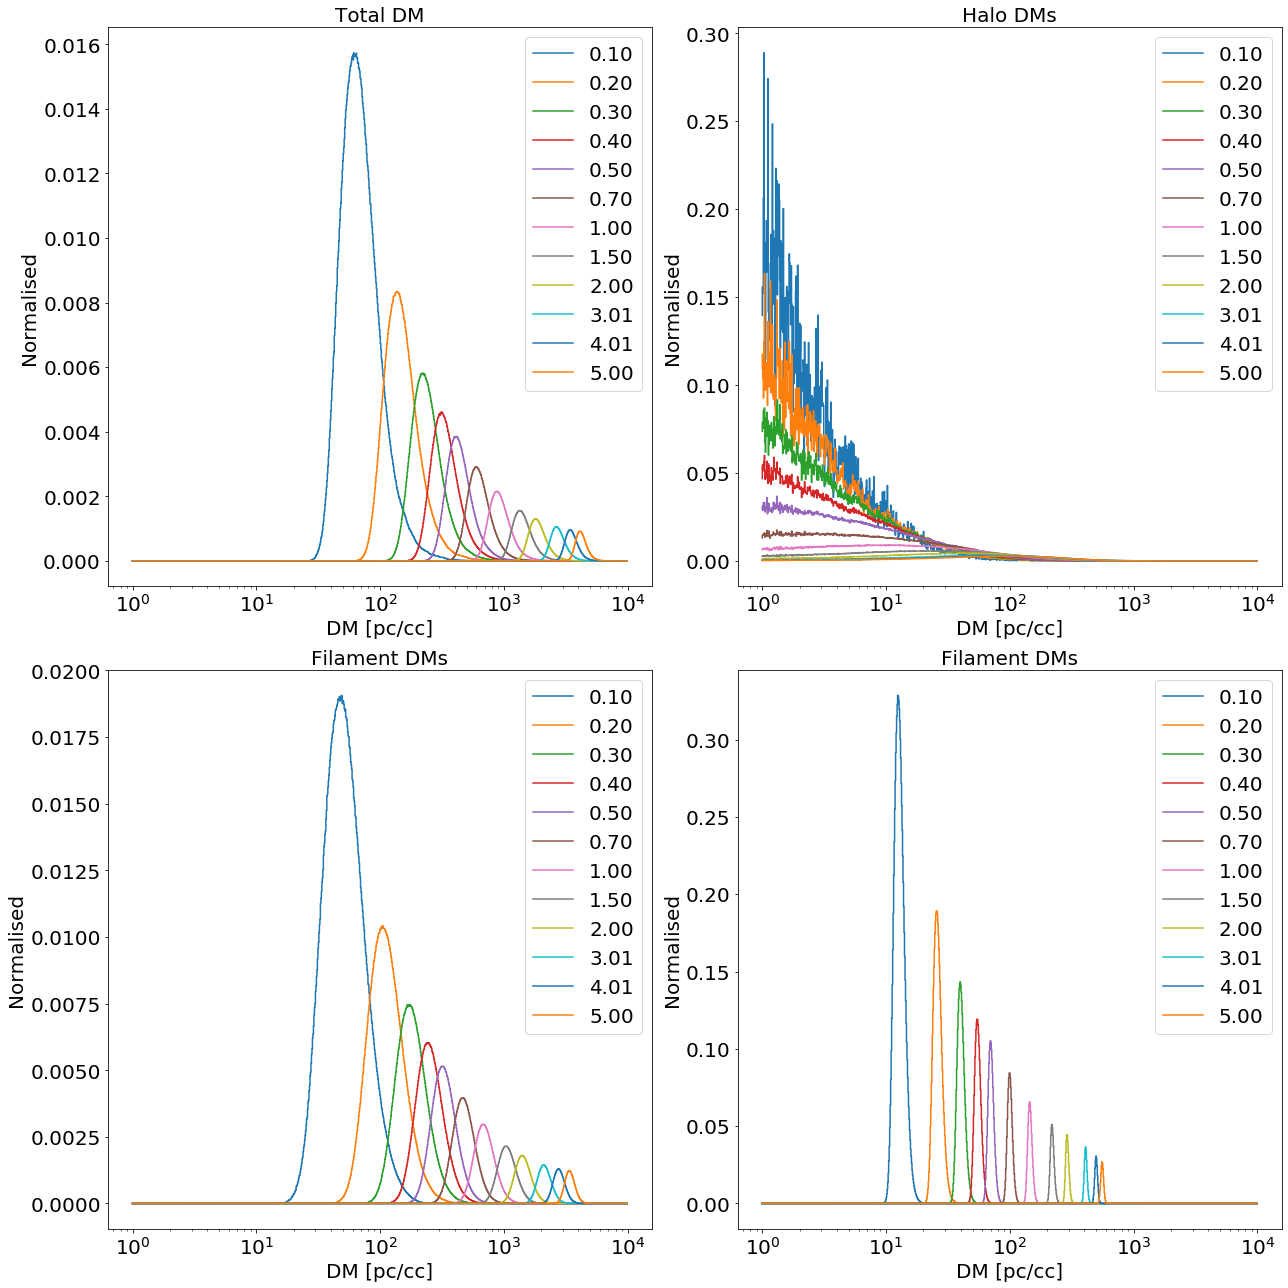

In [685]:
#################
#initialise plot#
#################

fig = plt.figure(figsize=(18,18))

#first subplot: total DM
ax1 = fig.add_subplot(221)
ax1.set_title('Total DM',fontsize=20)
ax1.set_xlabel('DM [pc/cc]',fontsize=20)
ax1.set_ylabel('Normalised',fontsize=20)
ax1.set_xscale('log')
ax1.tick_params(axis='both',which='major',labelsize=20)

#second subplot: DM from halos
ax2 = fig.add_subplot(222)
ax2.set_title('Halo DMs',fontsize=20)
ax2.set_xlabel('DM [pc/cc]',fontsize=20)
ax2.set_ylabel('Normalised',fontsize=20)
ax2.set_xscale('log')
ax2.tick_params(axis='both',which='major',labelsize=20)

#third subplot: DM from filaments
ax3 = fig.add_subplot(223)
ax3.set_title('Filament DMs',fontsize=20)
ax3.set_xlabel('DM [pc/cc]',fontsize=20)
ax3.set_ylabel('Normalised',fontsize=20)
ax3.set_xscale('log')
ax3.tick_params(axis='both',which='major',labelsize=20)

#fourth subplot: DM from voids
ax4 = fig.add_subplot(224)
ax4.set_title('Filament DMs',fontsize=20)
ax4.set_xlabel('DM [pc/cc]',fontsize=20)
ax4.set_ylabel('Normalised',fontsize=20)
ax4.set_xscale('log')
ax4.tick_params(axis='both',which='major',labelsize=20)

#loop over histograms to plot (exclude first snapshot at redshift zero as we have no data for this)
for i in range(1,len(snap_z_list)):
    print('loop: {0}, redshift: {1:.2f}'.format(i,snap_z_list[i]))

    #plot the total DM
    ax1.step(x=bin_edges[:-1],y=Tot_DM_norm[i],label='{0:.2f}'.format(snap_z_list[i]))
    
    #plot the DM from halos
    ax2.step(x=bin_edges[:-1],y=Hal_DM_norm[i],label='{0:.2f}'.format(snap_z_list[i]))
    
    #plot the DM from filaments
    ax3.step(x=bin_edges[:-1],y=Fil_DM_norm[i],label='{0:.2f}'.format(snap_z_list[i]))
    
    #plot the DM from voids
    ax4.step(x=bin_edges[:-1],y=Voi_DM_norm[i],label='{0:.2f}'.format(snap_z_list[i]))


ax1.legend(fontsize=20)
ax2.legend(fontsize=20)
ax3.legend(fontsize=20)
ax4.legend(fontsize=20)

plt.tight_layout()
plt.show()


### The un-normalised histograms

loop: 1, redshift: 0.10
loop: 2, redshift: 0.20
loop: 3, redshift: 0.30
loop: 4, redshift: 0.40
loop: 5, redshift: 0.50
loop: 6, redshift: 0.70
loop: 7, redshift: 1.00
loop: 8, redshift: 1.50
loop: 9, redshift: 2.00
loop: 10, redshift: 3.01
loop: 11, redshift: 4.01
loop: 12, redshift: 5.00


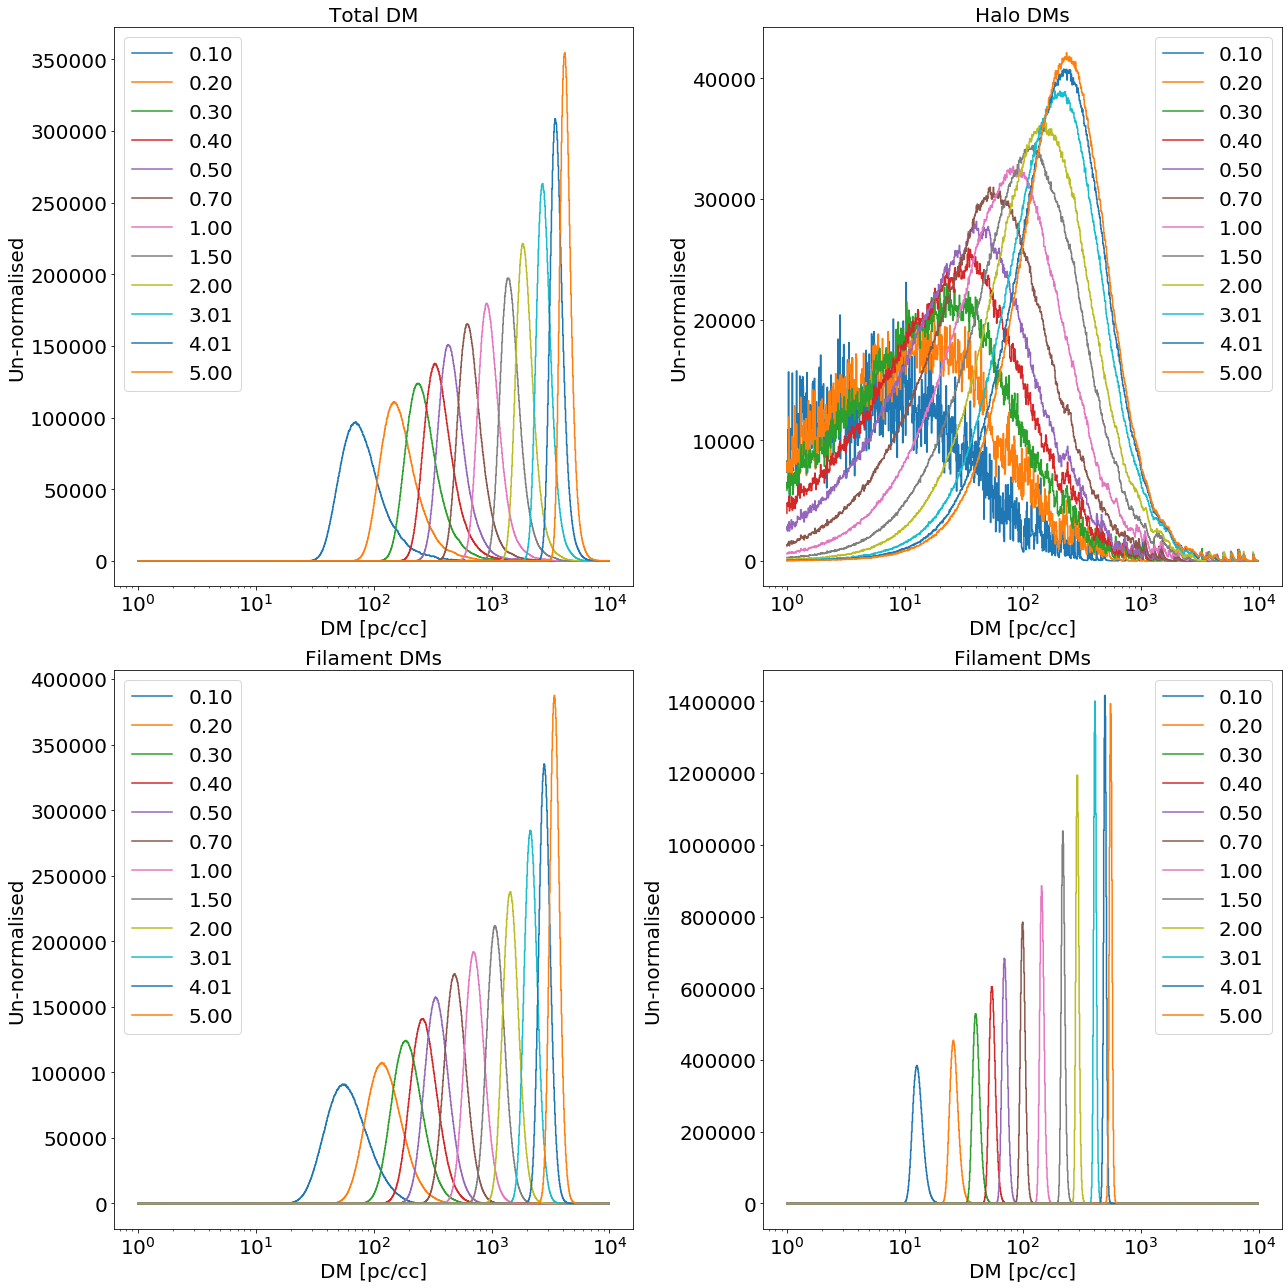

In [686]:
#################
#initialise plot#
#################

fig = plt.figure(figsize=(18,18))

#first subplot: total DM
ax1 = fig.add_subplot(221)
ax1.set_title('Total DM',fontsize=20)
ax1.set_xlabel('DM [pc/cc]',fontsize=20)
ax1.set_ylabel('Un-normalised',fontsize=20)
ax1.set_xscale('log')
ax1.tick_params(axis='both',which='major',labelsize=20)

#second subplot: DM from halos
ax2 = fig.add_subplot(222)
ax2.set_title('Halo DMs',fontsize=20)
ax2.set_xlabel('DM [pc/cc]',fontsize=20)
ax2.set_ylabel('Un-normalised',fontsize=20)
ax2.set_xscale('log')
ax2.tick_params(axis='both',which='major',labelsize=20)

#third subplot: DM from filaments
ax3 = fig.add_subplot(223)
ax3.set_title('Filament DMs',fontsize=20)
ax3.set_xlabel('DM [pc/cc]',fontsize=20)
ax3.set_ylabel('Un-normalised',fontsize=20)
ax3.set_xscale('log')
ax3.tick_params(axis='both',which='major',labelsize=20)

#fourth subplot: DM from voids
ax4 = fig.add_subplot(224)
ax4.set_title('Filament DMs',fontsize=20)
ax4.set_xlabel('DM [pc/cc]',fontsize=20)
ax4.set_ylabel('Un-normalised',fontsize=20)
ax4.set_xscale('log')
ax4.tick_params(axis='both',which='major',labelsize=20)

#loop over histograms to plot (exclude first snapshot at redshift zero as we have no data for this)
for i in range(1,len(snap_z_list)):
    print('loop: {0}, redshift: {1:.2f}'.format(i,snap_z_list[i]))

    #plot the total DM
    ax1.step(x=bin_edges[:-1],y=Tot_DM_unorm[i],label='{0:.2f}'.format(snap_z_list[i]))
    
    #plot the DM from halos
    ax2.step(x=bin_edges[:-1],y=Hal_DM_unorm[i],label='{0:.2f}'.format(snap_z_list[i]))
    
    #plot the DM from filaments
    ax3.step(x=bin_edges[:-1],y=Fil_DM_unorm[i],label='{0:.2f}'.format(snap_z_list[i]))
    
    #plot the DM from voids
    ax4.step(x=bin_edges[:-1],y=Voi_DM_unorm[i],label='{0:.2f}'.format(snap_z_list[i]))


ax1.legend(fontsize=20)
ax2.legend(fontsize=20)
ax3.legend(fontsize=20)
ax4.legend(fontsize=20)

plt.tight_layout()
plt.show()


### New histograms from original data vs loaded histograms as a check that data is consistent

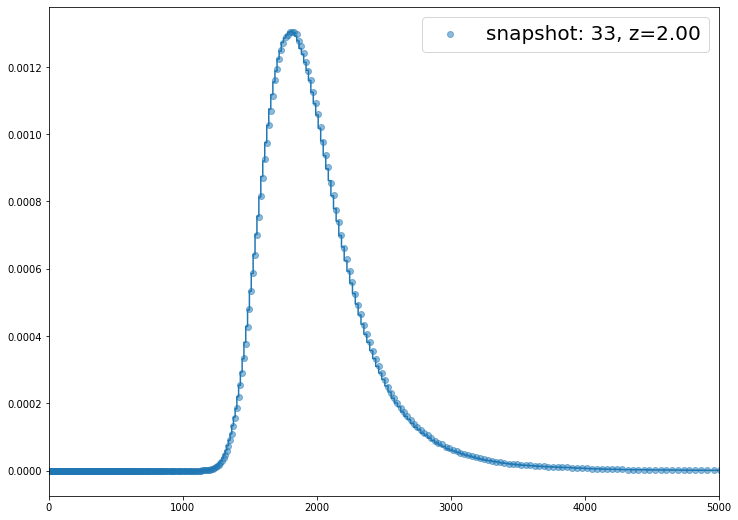

In [687]:
#re-histogram the raw data
bin_edges_new = np.logspace(0,4,num=1000)

snap_idx = 9#index of snapshot to check
snap_number = [99,91,84,78,72,67,59,50,40,33,25,21,17][snap_idx]
snap_redshift = snap_z_list[snap_idx]
count_check,bin_check=np.histogram(Tot_data[snap_idx],bin_edges_new,density=True)

#plot it against loaded histograms
fig = plt.figure(figsize=(12,9))
ax = fig.add_subplot(111)
ax.set_xlim([0,5000])
ax.step(bin_check[:-1],count_check)
ax.scatter(bin_edges[:-1],Tot_DM_norm[snap_idx],alpha=0.5,label='snapshot: {0}, z={1:.2f}'.format(int(snap_number),snap_redshift))

ax.legend(fontsize=20)

# Histogram the log of the halo data, because we can fit better to the log of DM


In [688]:
#initialise arrays to hold histogram outputs
Hal_DM_norm_new_counts = [] 
Hal_DM_norm_new_bins = []

bin_edges_new = np.logspace(0,4,num=1000) #bin edges for histogramming

#loop over snapshots
for data in [DMs_Hal_99,
          DMs_Hal_91,
          DMs_Hal_84,
          DMs_Hal_78,
          DMs_Hal_72,
          DMs_Hal_67,
          DMs_Hal_59,
          DMs_Hal_50,
          DMs_Hal_40,
          DMs_Hal_33,
          DMs_Hal_25,
          DMs_Hal_21,
          DMs_Hal_17]:
    
    #log the data
    data=np.log(data)
    #get rid of negative values (which go nan when you log)
    tokeep = np.invert(np.isnan(np.log(data)))
    data = data[tokeep]
    
    #histogram
    counts,bins = np.histogram(data,bin_edges_new,density=True)
    #append to results arrays
    Hal_DM_norm_new_counts.append(counts)
    Hal_DM_norm_new_bins.append(bins)


In [689]:
print(Hal_DM_norm_new_counts[1].shape)

(999,)


## Test of inversion sampling which will be used to sample from halo distribution

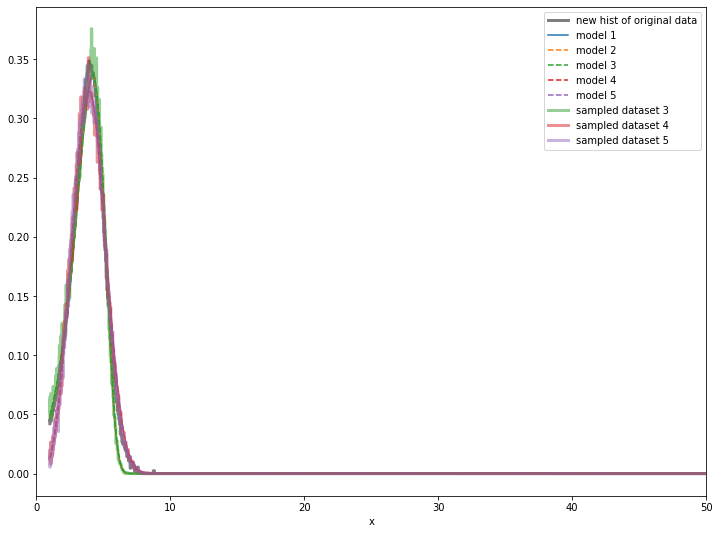

In [1135]:
#note: inversion sampling method from:
# https://cosmiccoding.com.au/tutorials/inversion_sampling

##### decide which snapshot to test
snap_id = 6

#get data we will fit
my_data = Hal_data[snap_id]

#log the data as we can fit it better that way
my_data = np.log(my_data)

#histogram data
counts_original,bins_original = np.histogram(my_data,bins=bin_edges_new,density=True)


# the x and y to fit. y will be the histogrammed counts. x will be the bins
x = bins_original[:-1]#np.log(bins_original[:-1])
y = counts_original

#initialise fit parameters for some custom distributions
m1_init   = my_model(loc=3.35,scale=1.58)
m2_init   = my_model_2(loc=3.35,scale=1.58)
m3_init   = my_model_3(amp=1,loc=3.35,scale=1.58)
m4_init   = my_model_4(amp=1,loc=3.35,scale=1.58)
m5_init   = my_model_5(amp=1,loc=3.35,scale=1.58,amp2=1,loc2=10,scale2=1.58)

#declare the fitter to be used
m1_Fitter = fitting.LevMarLSQFitter()
m2_Fitter = fitting.LevMarLSQFitter()
m3_Fitter = fitting.LevMarLSQFitter()
m4_Fitter = fitting.LevMarLSQFitter()
m5_Fitter = fitting.LevMarLSQFitter()

#fit custom distributions for better parameters
m1_Fitted = m1_Fitter(m1_init,x,y)
m2_Fitted = m2_Fitter(m2_init,x,y)
m3_Fitted = m3_Fitter(m3_init,x,y)
m4_Fitted = m4_Fitter(m4_init,x,y)
m5_Fitted = m5_Fitter(m5_init,x,y)

#get cdf and sample via inversion sampling and histogram the sample
fn1 = get_inverted_cdf(x, m1_Fitted(x))
sample1 = sample_fn(fn1, n=100000)
counts_samp1,bins_samp1 = np.histogram(sample1,bins=bin_edges_new,density=True)

fn2 = get_inverted_cdf(x, m2_Fitted(x))
sample2 = sample_fn(fn2, n=100000)
counts_samp2,bins_samp2 = np.histogram(sample2,bins=bin_edges_new,density=True)

fn3 = get_inverted_cdf(x, m3_Fitted(x))
sample3 = sample_fn(fn3, n=100000)
counts_samp3,bins_samp3 = np.histogram(sample3,bins=bin_edges_new,density=True)

fn4 = get_inverted_cdf(x, m4_Fitted(x))
sample4 = sample_fn(fn4, n=100000)
counts_samp4,bins_samp4 = np.histogram(sample4,bins=bin_edges_new,density=True)

fn5 = get_inverted_cdf(x, m5_Fitted(x))
sample5 = sample_fn(fn5, n=100000)
counts_samp5,bins_samp5 = np.histogram(sample5,bins=bin_edges_new,density=True)

#visualise

fig = plt.figure(figsize=(12,9))
ax1 = fig.add_subplot(111)
ax1.set_xlim([0,50])

ax1.step(x,counts_original,color='k',alpha=0.5,lw=3,label='new hist of original data')
ax1.plot(x, m1_Fitted(x), label="model 1")
ax1.plot(x, m2_Fitted(x), ls='--',label="model 2")
ax1.plot(x, m3_Fitted(x), ls='--',label="model 3")
ax1.plot(x, m4_Fitted(x), ls='--',label="model 4")
ax1.plot(x, m5_Fitted(x), ls='--',label="model 5")

#ax1.step(x,counts_samp1,color='C0',alpha=0.5,lw=3,label='sampled dataset 1')
#ax1.step(x,counts_samp2,color='C1',alpha=0.5,lw=3,label='sampled dataset 2')
ax1.step(x,counts_samp3,color='C2',alpha=0.5,lw=3,label='sampled dataset 3')
ax1.step(x,counts_samp4,color='C3',alpha=0.5,lw=3,label='sampled dataset 4')
ax1.step(x,counts_samp5,color='C4',alpha=0.5,lw=3,label='sampled dataset 5')

plt.xlabel("x"), plt.legend();

## Define functions we will use to fit histograms

In [690]:
#Hal_function = fisk
#Fil_function = lognorm
#Voi_function = lognorm


# Perform the fitting

In [697]:
#do the fitting

######################
#Fit filament portion#
######################

#define data to fit
data_to_fit = [DMs_Fil_91,
               DMs_Fil_84,
               DMs_Fil_78,
               DMs_Fil_72,
               DMs_Fil_67,
               DMs_Fil_59,
               DMs_Fil_50,
               DMs_Fil_40,
               DMs_Fil_33,
               DMs_Fil_25,
               DMs_Fil_21,
               DMs_Fil_17] #the data which will be fitted

#initialise parameters which go into fits
#Note: Filaments will be fit with a lognormal
#which uses shape, loc, scale

Fil_shapes = [] #shape parameter
Fil_locs = [] #location parameter
Fil_scales = [] #scale parameter

#loop over data, obtain parameters
for i in range(len(data_to_fit)):
    
    #select data to fit
    data=data_to_fit[i][::10] #for speed, only fit to a subsection. can do full dataset in final product.
    
    #fit data
    shape,loc,scale = lognorm.fit(data)
    
    #append to arrays
    Fil_shapes.append(shape)
    Fil_locs.append(loc)
    Fil_scales.append(scale)
    print(shape,loc,scale)
    

0.5122960878453287 11.764909502103748 47.38107230693287
0.4585879942866359 29.335937227397736 94.33083703316245
0.40027686563662046 47.93589542135615 146.42713108380215
0.3572873117809394 69.50344911017606 199.67505647369887
0.3230337278328469 91.92433883950736 255.20935103620377
0.2899507625851893 133.97994445855306 364.0253894404093
0.28362125500965474 225.7529783096603 498.54741987770774
0.26246034874725266 362.4400891740197 736.7395063390481
0.24569552016118923 532.323297584564 937.7936050079329
0.2121928164277861 836.5628728708915 1338.2375886642062
0.18786907821126905 1167.0043365910242 1678.8759949676778
0.17090217740360447 1522.7173374790486 1942.9011838475485


In [698]:
##################
#Fit void portion#
##################

#define data to fit
data_to_fit = [DMs_Voi_91,
               DMs_Voi_84,
               DMs_Voi_78,
               DMs_Voi_72,
               DMs_Voi_67,
               DMs_Voi_59,
               DMs_Voi_50,
               DMs_Voi_40,
               DMs_Voi_33,
               DMs_Voi_25,
               DMs_Voi_21,
               DMs_Voi_17] #the data which will be fitted

#initialise parameters which go into fits
#Note: Voids will be fit with a lognormal
#which uses shape, loc, scale

Voi_shapes = [] #shape parameter
Voi_locs = [] #location parameter
Voi_scales = [] #scale parameter

#loop over data, obtain parameters
for i in range(len(data_to_fit)):
    
    #select data to fit
    data=data_to_fit[i][::10] #for speed, only fit to a subsection. can do full dataset in final product.
    
    #fit data
    shape,loc,scale = lognorm.fit(data)
    
    #append to arrays
    Voi_shapes.append(shape)
    Voi_locs.append(loc)
    Voi_scales.append(scale)
    print(shape,loc,scale)

0.25907388930267616 8.066536083893702 4.8948217631861155
0.25105517204514305 17.59025928448141 8.760485604657537
0.21872303008623162 27.510004602939954 13.161969373374898
0.19357225609343515 38.03209566849354 17.640971490165384
0.17509582027745757 49.10054669689501 22.025772302153072
0.1621572680136773 71.72274120142887 29.462844087622955
0.1779577229887404 112.03113224422991 34.93023657838695
0.19924110892077956 181.42483173765004 40.605105144133574
0.16673438248124334 238.47361202470387 55.382424966830484
0.19650225843733815 356.54801523014794 57.29643179213804
0.07337287534542945 322.6546211943759 180.44618479455522
0.05372200947870179 285.0746441826219 277.51592611969306


## Old version of fitting halo portion (with a fisk)

In [1065]:
#figuring out best function to fit halo portion: 
# https://stackoverflow.com/questions/6620471/fitting-empirical-distribution-to-theoretical-ones-with-scipy-python

##################
#Fit halo portion#
##################

#define data to fit
data_to_fit = [DMs_Hal_91,
               DMs_Hal_84,
               DMs_Hal_78,
               DMs_Hal_72,
               DMs_Hal_67,
               DMs_Hal_59,
               DMs_Hal_50,
               DMs_Hal_40,
               DMs_Hal_33,
               DMs_Hal_25,
               DMs_Hal_21,
               DMs_Hal_17] #the data which will be fitted

#initialise parameters which go into fits
#Note: Halos will be fit with a fisk
#which uses c, loc, scale

Hal_fisk_cs = [] #c parameter
Hal_fisk_locs = [] #location parameter
Hal_fisk_scales = [] #scale parameter

#loop over data, obtain parameters
for i in range(len(data_to_fit)):
    
    #select data to fit
    data=data_to_fit[i][::1000] #for speed, only fit to a subsection. can do full dataset in final product.
    
    #note: we have to log the data to get the best fits.
    #thus we must get rid of negative values (which go nan when you log)
    #and when we draw from distributions, we must exp the values we draw afterwards

    data=np.log(data)
    tokeep = np.invert(np.isnan(np.log(data)))
    data = data[tokeep]
    
    #get initial guess for fit:
    #print(gilbrat._fitstart(data))
    #print(gilbrat.fit(data,loc=0))
    
    #fit data
    #loc,scale = gilbrat.fit(data,loc=0) #make starting condition for loc = 0
    c,loc,scale = fisk.fit(data,loc=-44.38,scale=47.24) #make starting condition for loc = 0
    print(Halo_Custom_Dist(amp=0,loc=0,scale=0).fit(data=data))
    print(amp,loc,scale)

    
    #append to arrays
    Hal_fisk_cs.append(c)
    Hal_fisk_locs.append(loc)
    Hal_fisk_scales.append(scale)
    print(c,loc,scale)

/mpcdf/soft/SLE_15/packages/x86_64/anaconda/3/2020.02/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1695: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  return integrate.quad(self._mom_integ1, 0, 1, args=(m,)+args)[0]


(0.0025000000000000014, 1.2325951644071314e-33)
4.1666666666666665e-05 -2.88129937446039 4.9129903506987205
6.429203270796739 -2.88129937446039 4.9129903506987205
(0.0025000000000000014, 1.2325951644071314e-33)
4.1666666666666665e-05 -9.231082639680125 11.72522350236904
14.41698161338708 -9.231082639680125 11.72522350236904
(0.0025000000000000014, 1.2325951644071314e-33)
4.1666666666666665e-05 -99.87526667835066 102.74219852650366
124.12842160837914 -99.87526667835066 102.74219852650366
(0.0025000000000000014, 1.2325951644071314e-33)
4.1666666666666665e-05 -112126918.73978838 112126921.90944767
137288777.8683225 -112126918.73978838 112126921.90944767
(0.0025000000000000014, 1.2325951644071314e-33)
4.1666666666666665e-05 -295362660.9667986 295362664.4086971
377330503.878257 -295362660.9667986 295362664.4086971
(0.0025000000000000014, 1.2325951644071314e-33)
4.1666666666666665e-05 -373305439.4624533 373305443.3048673
507477865.76606494 -373305439.4624533 373305443.3048673
(0.002500000000

## new version of fitting halo portion (with a custom distribution)

In [1241]:
##################
#Fit halo portion#
##################

#define data to fit
data_to_fit = [DMs_Hal_91,
               DMs_Hal_84,
               DMs_Hal_78,
               DMs_Hal_72,
               DMs_Hal_67,
               DMs_Hal_59,
               DMs_Hal_50,
               DMs_Hal_40,
               DMs_Hal_33,
               DMs_Hal_25,
               DMs_Hal_21,
               DMs_Hal_17] #the data which will be fitted

#define best initial guesses to optimise the fitting (figured out by hand)
amp2ig = [1,2.,0.22,1.,1.,1.,1.,1,1,1,1,1]
loc2ig = [0.15,7,10,10,10,10,10,10,10,10,10,10]
scale2ig = [1.58,1.58,0.5,1.58,1.58,1.58,1.58,1.58,1.58,1.58,1.58,1.58]


#initialise parameters which go into fits
#Note: Halos will be fit with a custom distribution
#modified from a gumbel_l distribution.
#It uses amp, loc, scale.
#but in this case, we will also store the model

Hal_cust_amps = [] #amplitude parameter (for the gumbel)
Hal_cust_locs = [] #location parameter (for the gumbel)
Hal_cust_scales = [] #scale parameter (for the gumbel)
Hal_cust_amps2 = [] #amplitude parameter 2 (for the gaussian)
Hal_cust_locs2 = [] #location parameter 2 (for the gaussian)
Hal_cust_scales2 = [] #scale parameter 2 (for the gaussian)
Hal_cust_models = []

#loop over data, obtain parameters
for i in range(len(data_to_fit)):
    
#select data to fit
    data=data_to_fit[i]
    
    #note: we have to log the data to get the best fits.
    #thus we must get rid of negative values (which go nan when you log)
    #and when we draw from distributions, we must exp the values we draw afterwards

    data=np.log(data)
    #tokeep = np.invert(np.isnan(np.log(data)))
    #data = data[tokeep]

    #histogram data
    counts_original,bins_original = np.histogram(data,
                                                 bins=bin_edges_new,
                                                 density=True)


    # the x and y to fit. y will be the histogrammed counts. x will be the bins
    x = bins_original[:-1]#np.log(bins_original[:-1])
    y = counts_original
    
    #initialise fit parameters for some custom distributions
    #m_init   = my_model_3(amp=1,loc=3.35,scale=1.58)
    #m_init   = my_model_4(amp=1,loc=3.35,scale=1.58)
    m_init   = my_model_5(amp=1,loc=3.35,scale=1.58,
                          amp2=amp2ig[i],loc2=loc2ig[i],scale2=scale2ig[i])

    #declare the fitter to be used
    m_Fitter = fitting.LevMarLSQFitter()

    #fit custom distributions for better parameters
    m_Fitted = m_Fitter(m_init,x,y)
    
    #save results to arrays
    Hal_cust_models.append(m_Fitted)
    Hal_cust_amps.append(m_Fitted.amp.value)
    Hal_cust_locs.append(m_Fitted.loc.value)
    Hal_cust_scales.append(m_Fitted.scale.value)
    Hal_cust_amps2.append(m_Fitted.amp2.value)
    Hal_cust_locs2.append(m_Fitted.loc2.value)
    Hal_cust_scales2.append(m_Fitted.scale2.value)



# Plot the fits

12 12 12
loop: 1, redshift: 0.10
loop: 2, redshift: 0.20
loop: 3, redshift: 0.30
loop: 4, redshift: 0.40
loop: 5, redshift: 0.50
loop: 6, redshift: 0.70
loop: 7, redshift: 1.00
loop: 8, redshift: 1.50
loop: 9, redshift: 2.00
loop: 10, redshift: 3.01
loop: 11, redshift: 4.01
loop: 12, redshift: 5.00


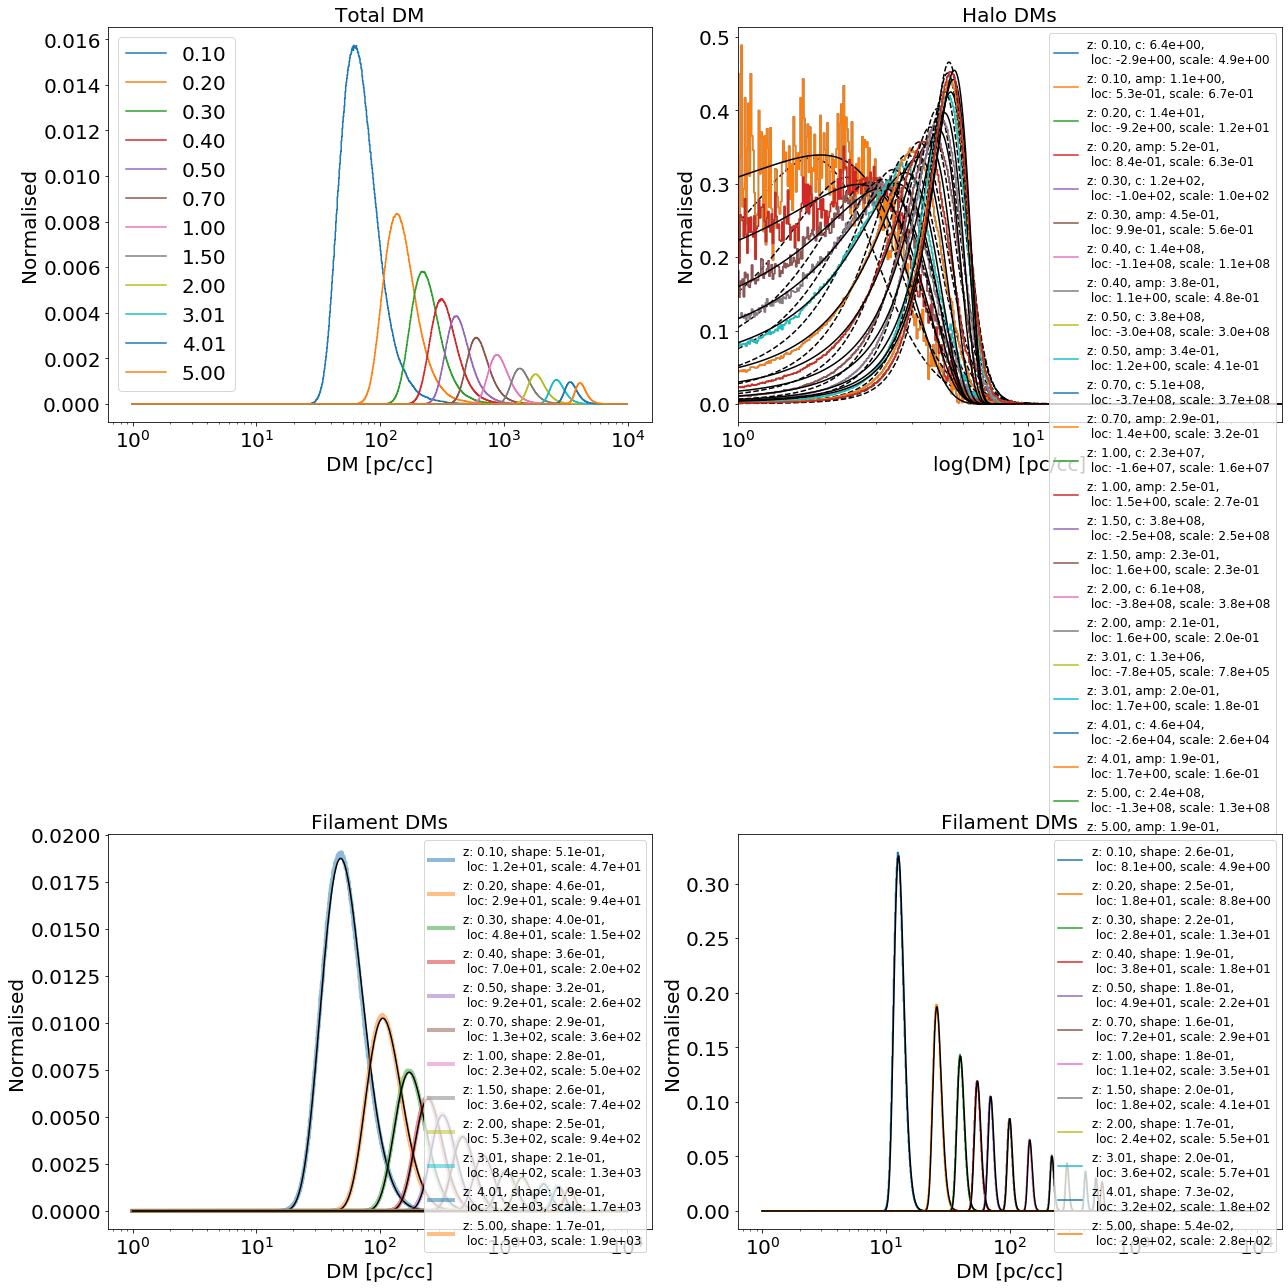

In [1242]:
# print(Hal_cs,Hal_locs,Hal_scales)
print(len(Fil_shapes),len(Fil_locs),len(Fil_scales))
#p = lognorm.pdf(x=bin_edges,s=Fil_shapes[1],loc=Fil_locs[1],scale=Fil_scales[1])
#print(p)

#################
#initialise plot#
#################

fig = plt.figure(figsize=(18,18))

#first subplot: total DM
ax1 = fig.add_subplot(221)
ax1.set_title('Total DM',fontsize=20)
ax1.set_xlabel('DM [pc/cc]',fontsize=20)
ax1.set_ylabel('Normalised',fontsize=20)
ax1.set_xscale('log')
ax1.tick_params(axis='both',which='major',labelsize=20)

#second subplot: DM from halos
ax2 = fig.add_subplot(222)
ax2.set_title('Halo DMs',fontsize=20)
ax2.set_xlabel('log(DM) [pc/cc]',fontsize=20)
ax2.set_ylabel('Normalised',fontsize=20)
ax2.set_xscale('log')
ax2.set_xlim([1,75])
ax2.tick_params(axis='both',which='major',labelsize=20)

#third subplot: DM from filaments
ax3 = fig.add_subplot(223)
ax3.set_title('Filament DMs',fontsize=20)
ax3.set_xlabel('DM [pc/cc]',fontsize=20)
ax3.set_ylabel('Normalised',fontsize=20)
ax3.set_xscale('log')
ax3.tick_params(axis='both',which='major',labelsize=20)

#fourth subplot: DM from voids
ax4 = fig.add_subplot(224)
ax4.set_title('Filament DMs',fontsize=20)
ax4.set_xlabel('DM [pc/cc]',fontsize=20)
ax4.set_ylabel('Normalised',fontsize=20)
ax4.set_xscale('log')
ax4.tick_params(axis='both',which='major',labelsize=20)

#loop over histograms to plot (exclude first snapshot at redshift zero as we have no data for this)
for i in range(1,len(snap_z_list)):
    print('loop: {0}, redshift: {1:.2f}'.format(i,snap_z_list[i]))

    #plot the total DM
    ax1.step(x=bin_edges[:-1],y=Tot_DM_norm[i],label='{0:.2f}'.format(snap_z_list[i]))
    
    #plot the DM from halos (fisk method)

    Hal_fisk_c = Hal_fisk_cs[i-1]
    Hal_fisk_loc = Hal_fisk_locs[i-1]
    Hal_fisk_scale = Hal_fisk_scales[i-1]
    
    p_fisk = fisk.pdf(x=bin_edges,c=Hal_fisk_c,loc=Hal_fisk_loc,scale=Hal_fisk_scale) #fitted pdf
    ax2.step(x=Hal_DM_norm_new_bins[i][:-1],
             y=Hal_DM_norm_new_counts[i],
             label='z: {0:.2f}, c: {1:.1e},\n loc: {2:.1e}, scale: {3:.1e}'.format(snap_z_list[i],
                                                                                   Hal_fisk_c,
                                                                                   Hal_fisk_loc,
                                                                                   Hal_fisk_scale))
    ax2.plot(bin_edges,p_fisk,color='k',ls='--') #plot fit    
    
    #plot the DM from halos (custom distribution method)
    Hal_cust_amp = Hal_cust_amps[i-1]
    Hal_cust_loc = Hal_cust_locs[i-1]
    Hal_cust_scale = Hal_cust_scales[i-1]
    p_cust = Hal_models[i-1] #the fitted pdf
        
    ax2.step(x=Hal_DM_norm_new_bins[i][:-1],
             y=Hal_DM_norm_new_counts[i],
             label='z: {0:.2f}, amp: {1:.1e},\n loc: {2:.1e}, scale: {3:.1e}'.format(snap_z_list[i],
                                                                                   Hal_cust_amp,
                                                                                   Hal_cust_loc,
                                                                                   Hal_cust_scale))
    ax2.plot(bin_edges,p_cust(bin_edges),color='k') #plot fit
    
    #plot the DM from filaments
    
    Fil_shape = Fil_shapes[i-1]
    Fil_loc = Fil_locs[i-1]
    Fil_scale = Fil_scales[i-1]

    p = lognorm.pdf(x=bin_edges,s=Fil_shape,loc=Fil_loc,scale=Fil_scale) #fitted pdf
    
    ax3.step(x=bin_edges[:-1],
             y=Fil_DM_norm[i],
             lw=4,
             alpha=0.5,
             label='z: {0:.2f}, shape: {1:.1e},\n loc: {2:.1e}, scale: {3:.1e}'.format(snap_z_list[i],
                                                                                       Fil_shape,
                                                                                       Fil_loc,
                                                                                       Fil_scale)) #histogram
    ax3.plot(bin_edges,p,color='k') #plot fit
    
    #plot the DM from voids
    
    Voi_shape = Voi_shapes[i-1]
    Voi_loc = Voi_locs[i-1]
    Voi_scale = Voi_scales[i-1]
    
    p = lognorm.pdf(x=bin_edges,s=Voi_shape,loc=Voi_loc,scale=Voi_scale) #fitted pdf

    ax4.step(x=bin_edges[:-1],
             y=Voi_DM_norm[i],
             label='z: {0:.2f}, shape: {1:.1e},\n loc: {2:.1e}, scale: {3:.1e}'.format(snap_z_list[i],
                                                                                       Voi_shape,
                                                                                       Voi_loc,
                                                                                       Voi_scale))
    ax4.plot(bin_edges,p,color='k') #plot fit

ax1.legend(fontsize=20)
ax2.legend(fontsize=12)
ax3.legend(fontsize=12)
ax4.legend(fontsize=12)

plt.tight_layout()
plt.show()

# Draw from our fitted distributions, compare to original data

1
2
3
4
5
6
7
8
9
10
11
12


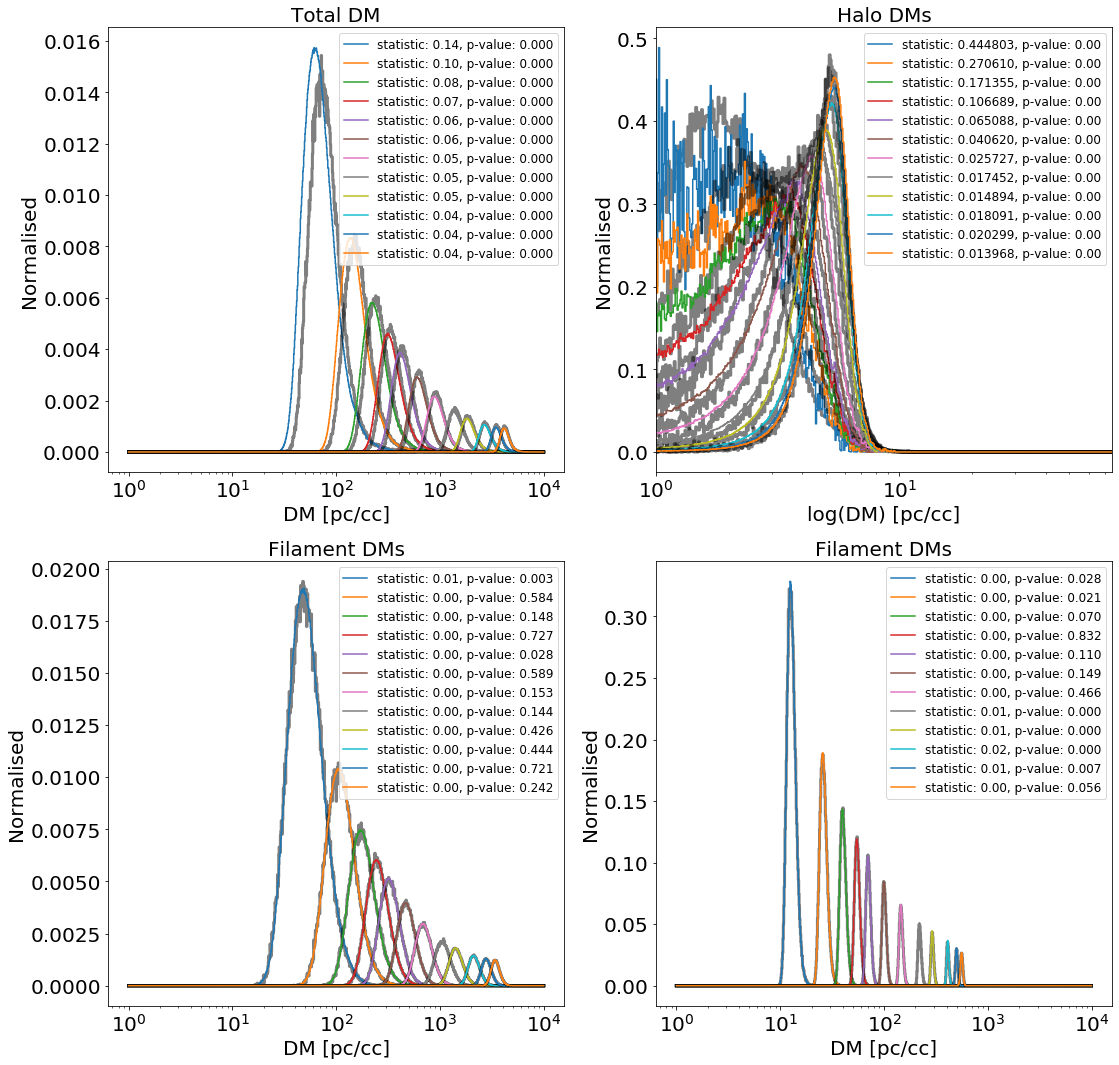

In [1244]:
#################
#initialise plot#
#################

fig = plt.figure(figsize=(18,18))

#first subplot: total DM
ax1 = fig.add_subplot(221)
ax1.set_title('Total DM',fontsize=20)
ax1.set_xlabel('DM [pc/cc]',fontsize=20)
ax1.set_ylabel('Normalised',fontsize=20)
ax1.set_xscale('log')
ax1.tick_params(axis='both',which='major',labelsize=20)

#second subplot: DM from halos
ax2 = fig.add_subplot(222)
ax2.set_title('Halo DMs',fontsize=20)
ax2.set_xlabel('log(DM) [pc/cc]',fontsize=20)
ax2.set_ylabel('Normalised',fontsize=20)
ax2.set_xscale('log')
ax2.set_xlim([1,75])
ax2.tick_params(axis='both',which='major',labelsize=20)

#third subplot: DM from filaments
ax3 = fig.add_subplot(223)
ax3.set_title('Filament DMs',fontsize=20)
ax3.set_xlabel('DM [pc/cc]',fontsize=20)
ax3.set_ylabel('Normalised',fontsize=20)
ax3.set_xscale('log')
ax3.tick_params(axis='both',which='major',labelsize=20)

#fourth subplot: DM from voids
ax4 = fig.add_subplot(224)
ax4.set_title('Filament DMs',fontsize=20)
ax4.set_xlabel('DM [pc/cc]',fontsize=20)
ax4.set_ylabel('Normalised',fontsize=20)
ax4.set_xscale('log')
ax4.tick_params(axis='both',which='major',labelsize=20)

#loop over snapshots to plot (exclude first snapshot at redshift zero as we have no data for this)
for i in range(1,len(snap_z_list)):
    
    print(i)

    #####################
    #draw data from fits#
    #####################
    
    ndraws = 100000 #number of samples to draw
    
    Fil_draws = lognorm.rvs(size=ndraws,s=Fil_shapes[i-1],loc=Fil_locs[i-1],scale=Fil_scales[i-1]) #filament (lognormal)
    Voi_draws = lognorm.rvs(size=ndraws,s=Voi_shapes[i-1],loc=Voi_locs[i-1],scale=Voi_scales[i-1]) #void (lognormal)

    
    #Halo draw, fisk method
    #Note: for halo have to only draw positive values, but the function can go below zero.
    #Thus loop, throwing away negative draws until we reach the right number
    Hal_fisk_draws = []
    while len(Hal_fisk_draws)!=ndraws:
        draw = fisk.rvs(size=1,c=Hal_fisk_cs[i-1],loc=Hal_fisk_locs[i-1],scale=Hal_fisk_scales[i-1])[0]
        if draw>=0:
            Hal_fisk_draws.append(draw)
    Hal_fisk_draws = np.array(Hal_fisk_draws)
    
    #Halo draw, custom dist method
    
    p_cust = Hal_cust_models[i-1] #the fitted pdf
    x=bin_edges_new #the bins used when creating the pdf
    fn3 = get_inverted_cdf(x, p_cust(x)) #get the inverted cdf
    Hal_cust_draws = sample_fn(fn3, n=ndraws) #draw from it via inverse sampling
    
    #Decide which to test
    #Hal_draws = Hal_cust_draws
    Hal_draws = Hal_fisk_draws
    
    #####################################################
    #Combine to create total DM from combined structures#
    #####################################################
    #Note, as Halo portion was fitted to the log of the DMs, must take the exponent
    Tot_draws = Fil_draws+Voi_draws+np.exp(Hal_draws) #combine the halo, fil, and void portions
    
    #Compare the draws to the original data with a 2-samp ks test
    #note, must exp the halo draws
    Hal_stats, Hal_pval = ks_2samp(np.exp(Hal_draws),Hal_data[i])
    Fil_stats, Fil_pval = ks_2samp(Fil_draws,Fil_data[i])
    Voi_stats, Voi_pval = ks_2samp(Voi_draws,Voi_data[i])
    Tot_stats, Tot_pval = ks_2samp(Tot_draws,Tot_data[i])
                                
    #####################
    #histogram the draws#
    #####################
    
    Fil_draw_counts,Fil_draw_bins=np.histogram(Fil_draws,bins=bin_edges_new,density=True) #filament
    Voi_draw_counts,Voi_draw_bins=np.histogram(Voi_draws,bins=bin_edges_new,density=True) #void
    Hal_draw_counts,Hal_draw_bins=np.histogram(Hal_draws,bins=bin_edges_new,density=True) #halo
    Tot_draw_counts,Tot_draw_bins=np.histogram(Tot_draws,bins=bin_edges_new,density=True) #halo

    #rehistogram the originals too
    #Fil_orig_c,Fil_orig_b = np.histogram(Fil_data[i],bins=bin_edges_new,density=True)
    #Hal_orig_c,Hal_orig_b = np.histogram(Hal_data[i],bins=bin_edges_new,density=True)
    #Voi_orig_c,Voi_orig_b = np.histogram(Voi_data[i],bins=bin_edges_new,density=True)
    #Tot_orig_c,Tot_orig_b = np.histogram(Tot_data[i],bins=bin_edges_new,density=True)

    
    #################################
    #plot the histogram of the draws#
    #################################
    
    ax3.step(Fil_draw_bins[:-1],Fil_draw_counts,color='k',alpha=0.5,lw=3) #filament
    ax4.step(Voi_draw_bins[:-1],Voi_draw_counts,color='k',alpha=0.5,lw=3) #void
    ax2.step(Hal_draw_bins[:-1],Hal_draw_counts,color='k',alpha=0.5,lw=3) #halo
    ax1.step(Tot_draw_bins[:-1],Tot_draw_counts,color='k',alpha=0.5,lw=3) #total DM

    #replot the rehistogrammed originals too
    #ax3.step(Fil_orig_b[:-1],Fil_orig_c)
    #ax4.step(Voi_orig_b[:-1],Voi_orig_c)
    #ax2.step(Hal_orig_b[:-1],Hal_orig_c)
    #ax1.step(Tot_orig_b[:-1],Tot_orig_c)

    
    #########################################
    #plot the histogram of the original data#
    #########################################
    
    ax3.step(x=bin_edges[:-1],y=Fil_DM_norm[i],label='statistic: {0:.2f}, p-value: {1:.3f}'.format(Fil_stats,Fil_pval)) #filament
    ax4.step(x=bin_edges[:-1],y=Voi_DM_norm[i],label='statistic: {0:.2f}, p-value: {1:.3f}'.format(Voi_stats,Voi_pval)) #void
    ax2.step(x=Hal_DM_norm_new_bins[i][:-1],y=Hal_DM_norm_new_counts[i],label='statistic: {0:3f}, p-value: {1:.2f}'.format(Hal_stats,Hal_pval)) #halo
    ax1.step(x=bin_edges[:-1],y=Tot_DM_norm[i],label='statistic: {0:.2f}, p-value: {1:.3f}'.format(Tot_stats,Tot_pval)) #total DM

ax1.legend(fontsize=12)
ax2.legend(fontsize=12)
ax3.legend(fontsize=12)
ax4.legend(fontsize=12)
    
plt.savefig('fits_new.png')





# Convolve our LSS fits to make sure results are consistent

## Note: this does not yet work.

In [1062]:
#create custom models to return what we want

@custom_model
def Halo_model(x,c=0,loc=0,scale=1):
    
    eqn = fisk.pdf(x,c=c,loc=loc,scale=scale)
    
    #note: it must return P(DM)=zero for DMs below zero
    #so modify by a function which is 1 for 0 and positive,
    #and zero for negative values. See:
    #https://math.stackexchange.com/questions/1403746/function-that-returns-0-for-all-negative-values

    eqn*=(0**(np.sqrt(x**2)-x))
    
    #note: as the fit was to the log of the DMs, must return the exponent if you want to return DM
    
    return np.exp(eqn)#eqn

@custom_model
def Filament_model(x,s=0,loc=0,scale=1):
    return lognorm.pdf(x,s=s,loc=loc,scale=scale)

@custom_model
def Void_model(x,s=0,loc=0,scale=1):
    return lognorm.pdf(x,s=s,loc=loc,scale=scale)

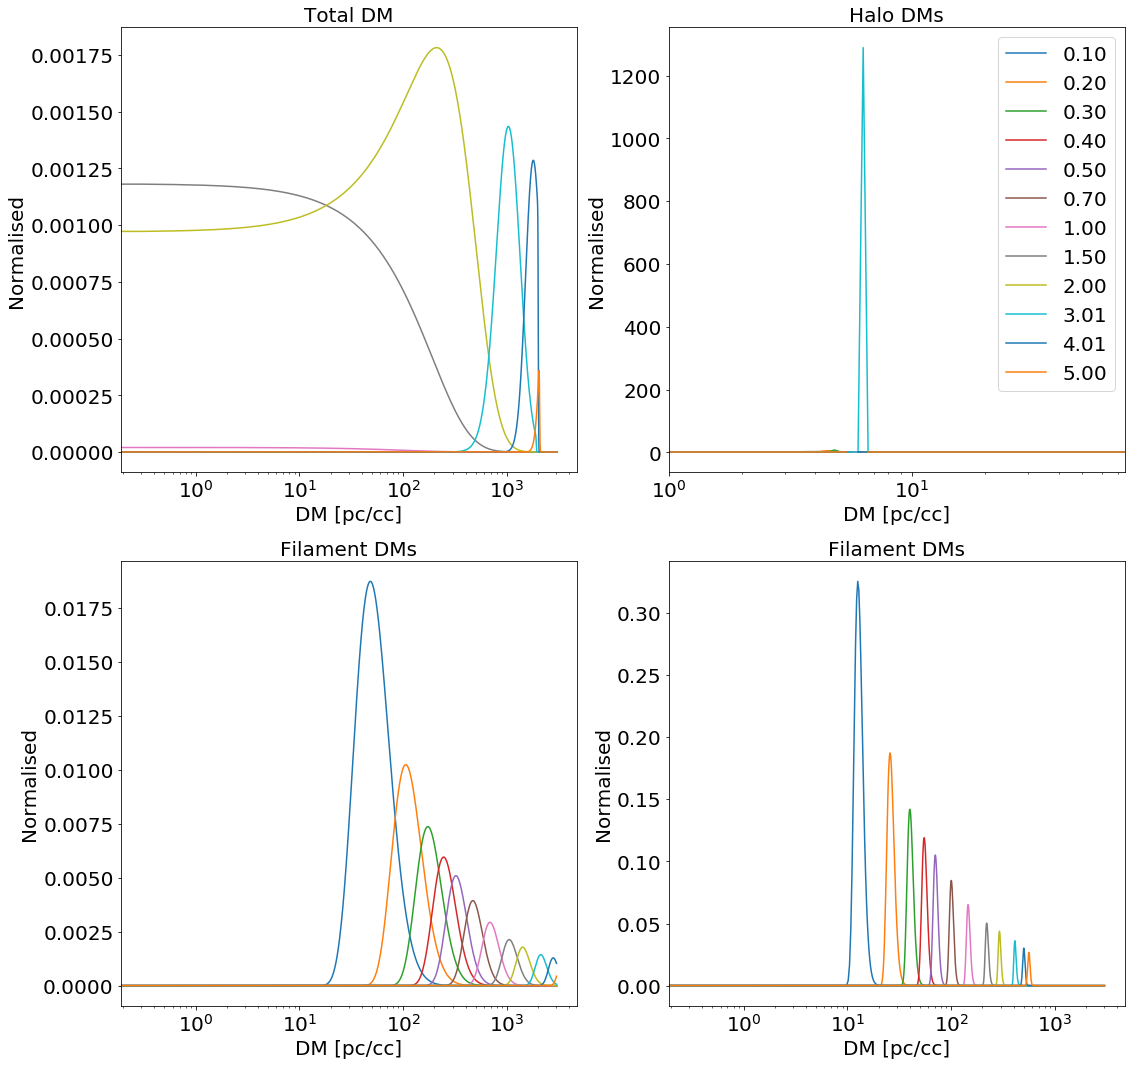

In [1063]:
#################
#initialise plot#
#################
from astropy.convolution import convolve_models

fig = plt.figure(figsize=(18,18))

#first subplot: total DM
ax1 = fig.add_subplot(221)
ax1.set_title('Total DM',fontsize=20)
ax1.set_xlabel('DM [pc/cc]',fontsize=20)
ax1.set_ylabel('Normalised',fontsize=20)
ax1.set_xscale('log')
ax1.tick_params(axis='both',which='major',labelsize=20)

#second subplot: DM from halos
ax2 = fig.add_subplot(222)
ax2.set_title('Halo DMs',fontsize=20)
ax2.set_xlabel('DM [pc/cc]',fontsize=20)
ax2.set_ylabel('Normalised',fontsize=20)
ax2.set_xscale('log')
ax2.set_xlim([1,75])
ax2.tick_params(axis='both',which='major',labelsize=20)

#third subplot: DM from filaments
ax3 = fig.add_subplot(223)
ax3.set_title('Filament DMs',fontsize=20)
ax3.set_xlabel('DM [pc/cc]',fontsize=20)
ax3.set_ylabel('Normalised',fontsize=20)
ax3.set_xscale('log')
ax3.tick_params(axis='both',which='major',labelsize=20)

#fourth subplot: DM from voids
ax4 = fig.add_subplot(224)
ax4.set_title('Filament DMs',fontsize=20)
ax4.set_xlabel('DM [pc/cc]',fontsize=20)
ax4.set_ylabel('Normalised',fontsize=20)
ax4.set_xscale('log')
ax4.tick_params(axis='both',which='major',labelsize=20)

#loop over snapshots to plot (exclude first snapshot at redshift zero as we have no data for this)
for i in range(1,len(snap_z_list)):
    
    #redshift
    z = snap_z_list[i]
    
    #declare x values
    x=np.linspace(0,3000,10000)
    
    #get y values for each LSS based on custom models
    Hal_y = Halo_model(c=Hal_cs[i-1],loc=Hal_locs[i-1],scale=Hal_scales[i-1])(x)
    Fil_y = Filament_model(s=Fil_shapes[i-1],loc=Fil_locs[i-1],scale=Fil_scales[i-1])(x)
    Voi_y = Void_model(s=Voi_shapes[i-1],loc=Voi_locs[i-1],scale=Voi_scales[i-1])(x)
    
    #Combine through convolution
    Combined_c = convolve_models(Filament_model(s=Fil_shapes[i-1],loc=Fil_locs[i-1],scale=Fil_scales[i-1]),
                                 Void_model(s=Voi_shapes[i-1],loc=Voi_locs[i-1],scale=Voi_scales[i-1])) #combine first two curves
    #Combined_c = convolve_models(Combined_c,
    #                             Halo_model(c=Hal_cs[i-1],loc=Hal_locs[i-1],scale=Hal_scales[i-1])) #combine final curve
    
    ax2.plot(x,Hal_y,label='{0:.2f}'.format(z))
    ax3.plot(x,Fil_y,label='{0:.2f}'.format(z))
    ax4.plot(x,Voi_y,label='{0:.2f}'.format(z))
    ax1.plot(x,Combined_c(x),label='{0:.2f}'.format(z))
    
ax2.legend(fontsize=20)

# Investigate a custom distribution for halos which works better than the fisk

In [930]:
@custom_model
def scipy_gumbel(x,amp=0.4,loc=0,scale=1):
    """
    Model of the Gumbel (minimum) distribution for fitting with astropy.
    Defining my own model is based on: https://docs.astropy.org/en/stable/modeling/new-model.html
    Distribution idea from: https://docs.astropy.org/en/stable/modeling/new-model.html
    Distribution from: https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.gumbel_l.html
    
    """
    
    #the original  gumbel function:
    eqn = amp*gumbel_l.pdf(x,loc,scale)
    
    #note: it must return P(DM)=zero for DMs below zero
    #so modify by a function which is 1 for 0 and positive,
    #and zero for negative values. See:
    #https://math.stackexchange.com/questions/1403746/function-that-returns-0-for-all-negative-values

    eqn*=(0**(np.sqrt(x**2)-x))
    
    return eqn

In [931]:
x=0.1
print((0**(np.sqrt(x**2)-x)))

1.0


In [932]:
Halo_Custom_Dist(amp=1,loc=0,scale=0).fit(data)

KeyboardInterrupt: 

In [909]:
#from: 
# https://stackoverflow.com/questions/71573674/how-to-fit-a-distribution-defined-with-scipy-stats-rv-continuous
#and:
# https://stackoverflow.com/questions/59939092/generating-random-numbers-from-custom-continuous-probability-density-function

def ZeroAtNegative(x):
    #if x<0:
    #    x=0
    #else:
    #    x=1
    
    #to prevent overflow errors, convert to an integer value. Equation works the same for ints and floats
    x=np.array(x).astype(int)
    eqn=(0**(np.sqrt(x**2)-x))
    return eqn
def Gumbel_with_Amp(x,amp,loc,scale):
    return(amp*gumbel_l.pdf(x,loc=loc,scale=scale))

class combo_dist_gen(stats.rv_continuous):
    "Halo custom distribution"
    def _pdf(self, x,  amp1, loc1, scale1):
        return (ZeroAtNegative(x)*Gumbel_with_Amp(x,amp1,loc1,scale1))

x=np.linspace(0,3000,10000)
    
combo_dist = combo_dist_gen(name='combo_dist',a=0,b=5000) #a and b fix the pdf to between 0 and 5000 to get it to work (see reference)


# Fit the data with the new distribution
# I provide initial values not too far from the original distribution
#fix the final two fit results as they appear but we don't need them (see reference)
amp,loc,scale,floc,fscale = combo_dist.fit(data[0:2],0,0,0,floc=0,fscale=1)


plt.plot(x,combo_dist(amp1=amp,loc1=loc,scale1=scale)(x))

KeyboardInterrupt: 

# Note: the below has potential
but errors when loc<=0. Need to fix. See: https://stackoverflow.com/questions/39420430/valueerror-domain-error-in-arguments-scipy-rv-continuous

and for a fix:

https://stackoverflow.com/questions/53322013/subclass-scipys-rv-continuous-with-custon-function

In [934]:
#from: https://stackoverflow.com/questions/51926560/creating-sample-from-custom-distribution-using-scipy

class halo3_pdf(rv_continuous):
    
    #def _argcheck(self, *args):
    #    """Default check for correct values on args and keywords.
    #    Returns condition array of 1's where arguments are correct and
    #     0's where they are not.
    #    """
    #    cond = 1
    #    for arg in args:
    #        cond = np.logical_and(cond, (np.asarray(arg) > -np.inf))
    #    return cond

    def _pdf(self,x,my_amp,my_loc,my_scale):
        
        """
        my_amp = the amplitude to multiply the gumbel_l by
        my_loc = the loc of the gumbel_l
        my_scale = the scale of the gumbel_l
        """
        
        
        
        #the original  gumbel function:
        eqn = my_amp*gumbel_l.pdf(x,my_loc,my_scale)

        #note: it must return P(DM)=zero for DMs below zero
        #so modify by a function which is 1 for 0 and positive,
        #and zero for negative values. See:
        #https://math.stackexchange.com/questions/1403746/function-that-returns-0-for-all-negative-values
        
        #note: make x int here to prevent overflow error
        #to prevent overflow errors, convert to an integer value. Equation works the same for ints and floats
        x=np.array(x).astype(int)
        eqn*=(0**(np.sqrt(x**2)-x))
        
        return eqn
    
#halo3 = halo3_pdf(name="halo")

#x = halo3.rvs(size=100,my_amp=1,my_loc=-6.8,my_scale=4.8)

#x

In [935]:
##### decide which snapshot to test
snap_id = 3

#the x (redshift) and y (normalised P(DM)) data which will be used to fit the custom distribution
x = np.log(bin_edges[:-1])
y = Hal_DM_norm[snap_id]



#initialise fit parameters for our custom distribution
Hal_init   = scipy_gumbel(amp=1,loc=3.35,scale=1.58)

#declare the fitter to be used
Hal_Fitter = fitting.LevMarLSQFitter()

#fit custom distribution for better parameters
Hal_Fitted = Hal_Fitter(Hal_init,x,y)

#draw values from custom distribution based on fitted parameters
#Custom_draws = Halo_Custom_Dist(amp=Hal_Fitted.amp.value,
#                                loc=Hal_Fitted.loc.value,
#                                scale=Hal_Fitted.scale.value).rvs(size=10000)

print(Hal_Fitted.amp.value,Hal_Fitted.loc.value,Hal_Fitted.scale.value)

#Custom_draws = halo3.rvs(size=100,
#                         my_amp=Hal_Fitted.amp.value,
#                         my_loc=Hal_Fitted.loc.value,
#                         my_scale=Hal_Fitted.scale.value)

##note: must exp the drawn values
#Custom_draws=np.exp(Custom_draws)

##histogram drawn values to compare to original data
#counts,bins = np.histogram(Custom_draws,bins=bin_edges_new,density=True)

#histogram original data as a comparison
counts_original,bins_original = np.histogram(Hal_data[snap_id],bins=bin_edges_new,density=True)






1.6867092298119295 -3.9846586583424357 4.312776674190961


[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1.]


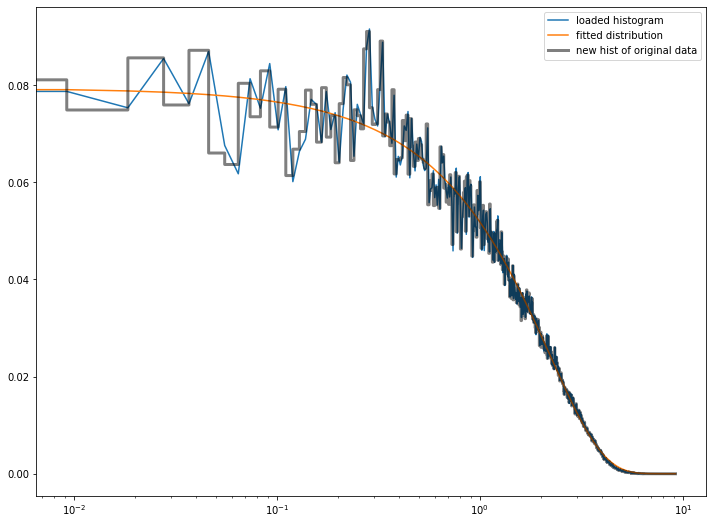

In [936]:
print(Custom_draws)
fig = plt.figure(figsize=(12,9))
ax=fig.add_subplot(111)
#ax.set_xlim([0.1,500])
ax.set_xscale('log')
ax.plot(x,y,label='loaded histogram')
ax.plot(x,Hal_Fitted(x),label='fitted distribution')
ax.step(x,counts_original,color='k',alpha=0.5,lw=3,label='new hist of original data')
#ax.step(x,counts,color='k',alpha=0.5,lw=3,label='hist of draws')

ax.legend()

# Method using inversion sampling
from https://cosmiccoding.com.au/tutorials/inversion_sampling

In [1212]:
@custom_model
def my_model(x,loc=0,scale=1):
    """
    Model of the Gumbel (minimum) distribution for fitting with astropy.
    Defining my own model is based on: https://docs.astropy.org/en/stable/modeling/new-model.html
    Distribution idea from: https://docs.astropy.org/en/stable/modeling/new-model.html
    Distribution from: https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.gumbel_l.html
    
    """
    
    #the original  gumbel function:
    eqn = gumbel_l.pdf(x,loc,scale)
    
    #note: it must return P(DM)=zero for DMs below zero
    #so modify by a function which is 1 for 0 and positive,
    #and zero for negative values. See:
    #https://math.stackexchange.com/questions/1403746/function-that-returns-0-for-all-negative-values

    eqn*=(0**(np.sqrt(x**2)-x))
    
    return eqn

@custom_model
def my_model_2(x,amp=1,loc=0,scale=1):
    """
    Model of the Gumbel (minimum) distribution for fitting with astropy.
    Defining my own model is based on: https://docs.astropy.org/en/stable/modeling/new-model.html
    Distribution idea from: https://docs.astropy.org/en/stable/modeling/new-model.html
    Distribution from: https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.gumbel_l.html
    
    """
    
    #the original  gumbel function derived myself:
    f=(x-loc)/scale
    eqn = np.exp(f-np.exp(f))/scale
    
    #eqn = amp*gumbel_l.pdf(x,loc,scale)
    
    #note: it must return P(DM)=zero for DMs below zero
    #so modify by a function which is 1 for 0 and positive,
    #and zero for negative values. See:
    #https://math.stackexchange.com/questions/1403746/function-that-returns-0-for-all-negative-values

    eqn*=(0**(np.sqrt(x**2)-x))
    
    return eqn

@custom_model
def my_model_3(x,amp=1,loc=0,scale=1):
    """
    Model of the Gumbel (minimum) distribution for fitting with astropy.
    Defining my own model is based on: https://docs.astropy.org/en/stable/modeling/new-model.html
    Distribution idea from: https://docs.astropy.org/en/stable/modeling/new-model.html
    Distribution from: https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.gumbel_l.html
    
    """
    
    #the original  gumbel function modified by an amplitude:
    f=(x-loc)/scale
    
    eqn = amp*np.exp(f-np.exp(f))/scale
    
    #eqn = amp*gumbel_l.pdf(x,loc,scale)
    
    #note: it must return P(DM)=zero for DMs below zero
    #so modify by a function which is 1 for 0 and positive,
    #and zero for negative values. See:
    #https://math.stackexchange.com/questions/1403746/function-that-returns-0-for-all-negative-values

    eqn*=(0**(np.sqrt(x**2)-x))
    
    return eqn

@custom_model
def my_model_4(x,amp=1,loc=0,scale=1):
    """
    Model of the Gumbel (minimum) distribution for fitting with astropy.
    Defining my own model is based on: https://docs.astropy.org/en/stable/modeling/new-model.html
    Distribution idea from: https://docs.astropy.org/en/stable/modeling/new-model.html
    Distribution from: https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.gumbel_l.html
    
    """
    
    x=np.log(x)
    
    #the original  gumbel function modified by an amplitude:
    f=(x-loc)/scale
    
    eqn = amp*np.exp(f-np.exp(f))/scale
    
    #eqn = amp*gumbel_l.pdf(x,loc,scale)
    
    #note: it must return P(DM)=zero for DMs below zero
    #so modify by a function which is 1 for 0 and positive,
    #and zero for negative values. See:
    #https://math.stackexchange.com/questions/1403746/function-that-returns-0-for-all-negative-values

    eqn*=(0**(np.sqrt(x**2)-x))
    
    return eqn


@custom_model
def my_model_5(x,amp=1,loc=0,scale=1,amp2=1,loc2=0,scale2=1):
    """
    Model of the Gumbel (minimum) distribution for fitting with astropy.
    Defining my own model is based on: https://docs.astropy.org/en/stable/modeling/new-model.html
    Distribution idea from: https://docs.astropy.org/en/stable/modeling/new-model.html
    Distribution from: https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.gumbel_l.html
    
    """
    #amp=0.44
    #loc=1,scale=0.55
    x=np.log(x)
    
    #the original  gumbel function modified by an amplitude:
    f=(x-loc)/scale
    
    eqn = amp*np.exp(f-np.exp(f))/scale
    
    #eqn = amp*gumbel_l.pdf(x,loc,scale)
    
    #note: it must return P(DM)=zero for DMs below zero
    #so modify by a function which is 1 for 0 and positive,
    #and zero for negative values. See:
    #https://math.stackexchange.com/questions/1403746/function-that-returns-0-for-all-negative-values

    eqn*=(0**(np.sqrt(x**2)-x))
    
    #multiply by something to boost the higher DM tail
    
    #try a gaussian
    g=(x-loc2)/scale2
    mod = amp2*np.exp(-1*(g**2)/2)/np.sqrt(2*np.pi)
    eqn+=mod
    
    
    
    return eqn

@custom_model
def my_model_6(x,amp=1,loc=0,scale=1,amp2=1,loc2=0,scale2=1,amp3=1,loc3=0,scale3=1):
    """
    Model of the Gumbel (minimum) distribution for fitting with astropy.
    Defining my own model is based on: https://docs.astropy.org/en/stable/modeling/new-model.html
    Distribution idea from: https://docs.astropy.org/en/stable/modeling/new-model.html
    Distribution from: https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.gumbel_l.html
    
    """
    
    x=np.log(x)
    
    #the original  gumbel function modified by an amplitude:
    f=(x-loc)/scale
    
    eqn = amp*np.exp(f-np.exp(f))/scale
    
    #eqn = amp*gumbel_l.pdf(x,loc,scale)
    
    #note: it must return P(DM)=zero for DMs below zero
    #so modify by a function which is 1 for 0 and positive,
    #and zero for negative values. See:
    #https://math.stackexchange.com/questions/1403746/function-that-returns-0-for-all-negative-values

    eqn*=(0**(np.sqrt(x**2)-x))
    
    #multiply by something to boost the higher DM tail
    
    #try 2 gaussians
    g=(x-loc2)/scale2
    mod = amp2*np.exp(-1*(g**2)/2)/np.sqrt(2*np.pi)
    eqn+=mod

    h=(x-loc3)/scale3
    mod = amp3*np.exp(-1*(h**2)/2)/np.sqrt(2*np.pi)
    eqn+=mod
    
    return eqn

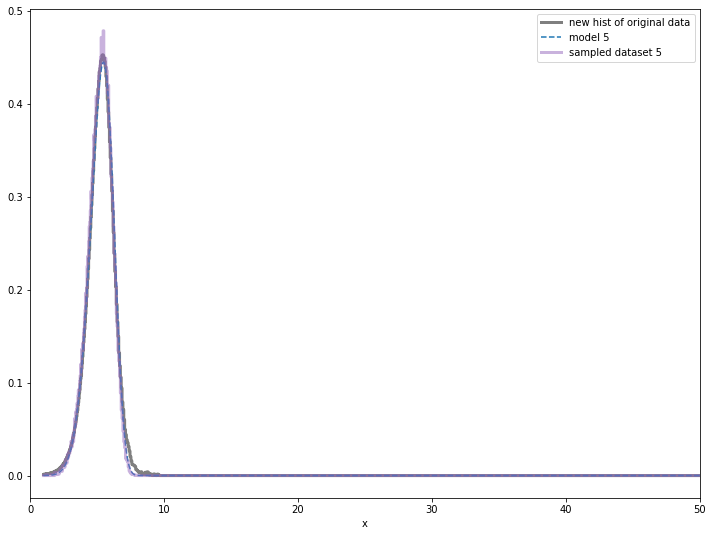

In [1240]:
#note: inversion sampling method from:
# https://cosmiccoding.com.au/tutorials/inversion_sampling

##### decide which snapshot to test
snap_id = 12

#store best initial guesses
amp2ig = [1.,1,2.,0.22,1.,1.,1.,1.,1,1,1,1,1]
loc2ig = [1.,0.15,7,10,10,10,10,10,10,10,10,10,10]
scale2ig = [1.,1.58,1.58,0.5,1.58,1.58,1.58,1.58,1.58,1.58,1.58,1.58,1.58]

#get data we will fit
my_data = Hal_data[snap_id]

#log the data as we can fit it better that way
my_data = np.log(my_data)

#histogram data
counts_original,bins_original = np.histogram(my_data,bins=bin_edges_new,density=True)


# the x and y to fit. y will be the histogrammed counts. x will be the bins
x = bins_original[:-1]#np.log(bins_original[:-1])
y = counts_original

#initialise fit parameters for some custom distributions
m1_init   = my_model(loc=3.35,scale=1.58)
m2_init   = my_model_2(loc=3.35,scale=1.58)
m3_init   = my_model_3(amp=1,loc=3.35,scale=1.58)
m4_init   = my_model_4(amp=1,loc=3.35,scale=1.58)
m5_init   = my_model_5(amp=1,loc=3.35,scale=1.58,amp2=amp2ig[snap_id],loc2=loc2ig[snap_id],scale2=scale2ig[snap_id])
m6_init   = my_model_6(amp=1,loc=3.35,scale=1.58,
                       amp2=1,loc2=10,scale2=1.58,
                       amp3=1,loc3=10,scale3=1.58)

#declare the fitter to be used
m1_Fitter = fitting.LevMarLSQFitter()
m2_Fitter = fitting.LevMarLSQFitter()
m3_Fitter = fitting.LevMarLSQFitter()
m4_Fitter = fitting.LevMarLSQFitter()
m5_Fitter = fitting.LevMarLSQFitter()
m6_Fitter = fitting.LevMarLSQFitter()

#fit custom distributions for better parameters
m1_Fitted = m1_Fitter(m1_init,x,y)
m2_Fitted = m2_Fitter(m2_init,x,y)
m3_Fitted = m3_Fitter(m3_init,x,y)
m4_Fitted = m4_Fitter(m4_init,x,y)
m5_Fitted = m5_Fitter(m5_init,x,y)
m6_Fitted = m6_Fitter(m6_init,x,y)

#get cdf and sample via inversion sampling and histogram the sample
fn1 = get_inverted_cdf(x, m1_Fitted(x))
sample1 = sample_fn(fn1, n=100000)
counts_samp1,bins_samp1 = np.histogram(sample1,bins=bin_edges_new,density=True)

fn2 = get_inverted_cdf(x, m2_Fitted(x))
sample2 = sample_fn(fn2, n=100000)
counts_samp2,bins_samp2 = np.histogram(sample2,bins=bin_edges_new,density=True)

fn3 = get_inverted_cdf(x, m3_Fitted(x))
sample3 = sample_fn(fn3, n=100000)
counts_samp3,bins_samp3 = np.histogram(sample3,bins=bin_edges_new,density=True)

fn4 = get_inverted_cdf(x, m4_Fitted(x))
sample4 = sample_fn(fn4, n=100000)
counts_samp4,bins_samp4 = np.histogram(sample4,bins=bin_edges_new,density=True)

fn5 = get_inverted_cdf(x, m5_Fitted(x))
sample5 = sample_fn(fn5, n=100000)
counts_samp5,bins_samp5 = np.histogram(sample5,bins=bin_edges_new,density=True)

fn6 = get_inverted_cdf(x, m6_Fitted(x))
sample6 = sample_fn(fn6, n=100000)
counts_samp6,bins_samp6 = np.histogram(sample6,bins=bin_edges_new,density=True)

#visualise

fig = plt.figure(figsize=(12,9))
ax1 = fig.add_subplot(111)
ax1.set_xlim([0,50])

ax1.step(x,counts_original,color='k',alpha=0.5,lw=3,label='new hist of original data')
#ax1.plot(x, m1_Fitted(x), label="model 1")
#ax1.plot(x, m2_Fitted(x), ls='--',label="model 2")
#ax1.plot(x, m3_Fitted(x), ls='--',label="model 3")
a#x1.plot(x, m4_Fitted(x), ls='--',label="model 4")
ax1.plot(x, m5_Fitted(x), ls='--',label="model 5")
#ax1.plot(x, m6_Fitted(x), ls='--',label="model 6")

#ax1.step(x,counts_samp1,color='C0',alpha=0.5,lw=3,label='sampled dataset 1')
#ax1.step(x,counts_samp2,color='C1',alpha=0.5,lw=3,label='sampled dataset 2')
#ax1.step(x,counts_samp3,color='C2',alpha=0.5,lw=3,label='sampled dataset 3')
#ax1.step(x,counts_samp4,color='C3',alpha=0.5,lw=3,label='sampled dataset 4')
ax1.step(x,counts_samp5,color='C4',alpha=0.5,lw=3,label='sampled dataset 5')
#ax1.step(x,counts_samp6,color='C5',alpha=0.5,lw=3,label='sampled dataset 6')

plt.xlabel("x"), plt.legend();